In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None

In [16]:

import glob
import os

files_path = "data/social_origins/sample_regions/*.csv"


files = glob.glob(files_path)

# Initialize an empty list to store individual dataframes
dfs = []

# Read each file and append to the list
for file in files:
    df = pd.read_csv(file, index_col = [0])
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
df_results = pd.concat(dfs, ignore_index=True)
df_results = df_results[~df_results['explanation'].str.contains('Error: Connection error')]

df_results = df_results.drop_duplicates('individual_wikidata_id', keep='first')
df_results['country'].value_counts()


df_results = df_results.rename(columns={'birth_year':'birthyear', 'country':'region_name'})


df_fig = df_results[['individual_wikidata_id', 'birthyear', 'classification', 'region_name']].copy()
regions = ['United Kingdom', 'Italy', 'Japan', 'China']

df_fig = df_fig[df_fig['region_name'].isin(regions)]

df_fig.dropna()


,individual_wikidata_id,birthyear,classification,region_name
2,Q4269655,1791,Elite,United Kingdom
3,Q5083355,1846,Middle Class,United Kingdom
6,Q64347096,1849,Middle Class,United Kingdom
7,Q310439,1624,Middle Class,United Kingdom
9,Q2369747,1762,Middle Class,United Kingdom
...,...,...,...,...
6314,Q3719531,1808,Elite,Italy
6319,Q595497,1543,Elite,Italy
6320,Q242532,1639,Elite,Italy
6323,Q4023586,1568,Middle Class,Italy


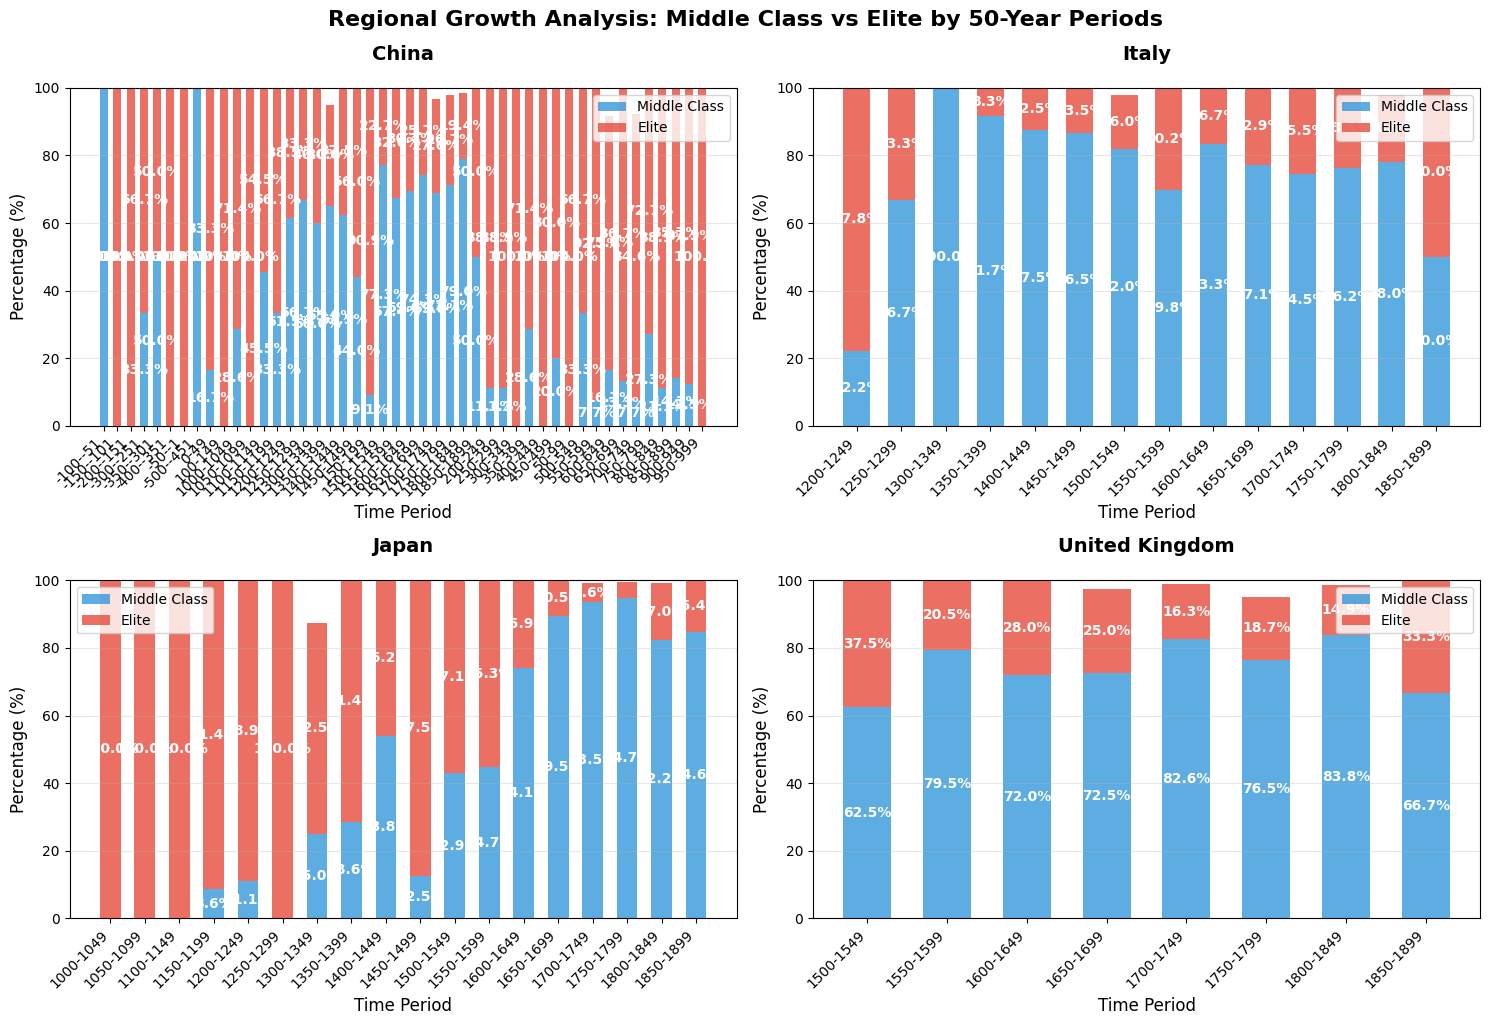


SUMMARY STATISTICS BY REGION

CHINA:
-----

  -100--51:
    Total individuals: 2
    Middle Class: 2 (100.0%)
    Elite: 0 (0.0%)

  -150--101:
    Total individuals: 2
    Middle Class: 0 (0.0%)
    Elite: 2 (100.0%)

  -200--151:
    Total individuals: 5
    Middle Class: 0 (0.0%)
    Elite: 5 (100.0%)

  -300--251:
    Total individuals: 6
    Middle Class: 2 (33.3%)
    Elite: 4 (66.7%)

  -350--301:
    Total individuals: 2
    Middle Class: 1 (50.0%)
    Elite: 1 (50.0%)

  -400--351:
    Total individuals: 1
    Middle Class: 0 (0.0%)
    Elite: 1 (100.0%)

  -50--1:
    Total individuals: 2
    Middle Class: 0 (0.0%)
    Elite: 2 (100.0%)

  -500--451:
    Total individuals: 1
    Middle Class: 1 (100.0%)
    Elite: 0 (0.0%)

  0-49:
    Total individuals: 6
    Middle Class: 1 (16.7%)
    Elite: 5 (83.3%)

  100-149:
    Total individuals: 5
    Middle Class: 0 (0.0%)
    Elite: 5 (100.0%)

  1000-1049:
    Total individuals: 21
    Middle Class: 6 (28.6%)
    Elite: 15 (71.4

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Assuming your dataframe is called df_fig
# df_fig = pd.read_csv('your_data.csv')  # Load your data

def analyze_regional_growth_by_class(df):
    """
    Analyze growth patterns by social class for each region over 50-year periods
    """
    
    # Create a copy to work with
    df_clean = df.dropna().copy()
    
    # Function to assign 50-year periods
    def get_period(year):
        return f"{(year // 50) * 50}-{(year // 50) * 50 + 49}"
    
    # Add period column
    df_clean['period'] = df_clean['birthyear'].apply(get_period)
    
    # Group by region, period, and classification
    growth_data = df_clean.groupby(['region_name', 'period', 'classification']).size().reset_index(name='count')
    
    # Calculate total per region-period
    period_totals = growth_data.groupby(['region_name', 'period'])['count'].sum().reset_index(name='total')
    
    # Merge to calculate percentages
    growth_data = growth_data.merge(period_totals, on=['region_name', 'period'])
    growth_data['percentage'] = (growth_data['count'] / growth_data['total']) * 100
    
    return growth_data

def create_regional_plots(growth_data):
    """
    Create separate plots for each region showing Middle Class vs Elite percentages
    """
    
    regions = growth_data['region_name'].unique()
    
    # Set up the plot layout
    n_regions = len(regions)
    cols = 2 if n_regions > 1 else 1
    rows = (n_regions + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if n_regions == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if isinstance(axes, np.ndarray) else [axes]
    else:
        axes = axes.flatten()
    
    colors = {'Middle Class': '#3498db', 'Elite': '#e74c3c'}
    
    for i, region in enumerate(regions):
        ax = axes[i]
        
        # Filter data for this region
        region_data = growth_data[growth_data['region_name'] == region]
        
        # Get all periods for this region and sort them
        periods = sorted(region_data['period'].unique())
        
        # Prepare data for plotting
        middle_class_pcts = []
        elite_pcts = []
        
        for period in periods:
            period_data = region_data[region_data['period'] == period]
            
            mc_data = period_data[period_data['classification'] == 'Middle Class']
            elite_data = period_data[period_data['classification'] == 'Elite']
            
            mc_pct = mc_data['percentage'].iloc[0] if len(mc_data) > 0 else 0
            elite_pct = elite_data['percentage'].iloc[0] if len(elite_data) > 0 else 0
            
            middle_class_pcts.append(mc_pct)
            elite_pcts.append(elite_pct)
        
        # Create stacked bar chart
        x_pos = np.arange(len(periods))
        width = 0.6
        
        bars1 = ax.bar(x_pos, middle_class_pcts, width, label='Middle Class', 
                      color=colors['Middle Class'], alpha=0.8)
        bars2 = ax.bar(x_pos, elite_pcts, width, bottom=middle_class_pcts, 
                      label='Elite', color=colors['Elite'], alpha=0.8)
        
        # Customize the plot
        ax.set_title(f'{region}', fontsize=14, fontweight='bold', pad=20)
        ax.set_xlabel('Time Period', fontsize=12)
        ax.set_ylabel('Percentage (%)', fontsize=12)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(periods, rotation=45, ha='right')
        ax.set_ylim(0, 100)
        ax.grid(axis='y', alpha=0.3)
        ax.legend()
        
        # Add percentage labels on bars
        for j, (mc_pct, elite_pct) in enumerate(zip(middle_class_pcts, elite_pcts)):
            if mc_pct > 5:  # Only show label if segment is large enough
                ax.text(j, mc_pct/2, f'{mc_pct:.1f}%', ha='center', va='center', 
                       fontweight='bold', color='white')
            if elite_pct > 5:
                ax.text(j, mc_pct + elite_pct/2, f'{elite_pct:.1f}%', ha='center', va='center', 
                       fontweight='bold', color='white')
    
    # Hide unused subplots
    for i in range(n_regions, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('Regional Growth Analysis: Middle Class vs Elite by 50-Year Periods', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.show()

def print_summary_statistics(growth_data):
    """
    Print summary statistics for each region
    """
    print("\n" + "="*60)
    print("SUMMARY STATISTICS BY REGION")
    print("="*60)
    
    for region in growth_data['region_name'].unique():
        region_data = growth_data[growth_data['region_name'] == region]
        print(f"\n{region.upper()}:")
        print("-" * len(region))
        
        for period in sorted(region_data['period'].unique()):
            period_data = region_data[region_data['period'] == period]
            print(f"\n  {period}:")
            
            total_count = period_data['total'].iloc[0] if len(period_data) > 0 else 0
            print(f"    Total individuals: {total_count}")
            
            for classification in ['Middle Class', 'Elite']:
                class_data = period_data[period_data['classification'] == classification]
                if len(class_data) > 0:
                    count = class_data['count'].iloc[0]
                    pct = class_data['percentage'].iloc[0]
                    print(f"    {classification}: {count} ({pct:.1f}%)")
                else:
                    print(f"    {classification}: 0 (0.0%)")


growth_data = analyze_regional_growth_by_class(df_fig.dropna())

# Create visualizations
create_regional_plots(growth_data)

# Print summary statistics
print_summary_statistics(growth_data)



# Additional analysis functions
def get_region_data_range(df):
    """
    Show the data range for each region
    """
    print("\nDATA RANGE BY REGION:")
    print("="*40)
    
    for region in df['region_name'].unique():
        region_data = df[df['region_name'] == region]
        min_year = region_data['birthyear'].min()
        max_year = region_data['birthyear'].max()
        count = len(region_data)
        print(f"{region}: {min_year}-{max_year} ({count} individuals)")

def analyze_class_dominance(growth_data):
    """
    Analyze which class dominates in each period for each region
    """
    print("\nCLASS DOMINANCE BY PERIOD:")
    print("="*50)
    
    for region in growth_data['region_name'].unique():
        print(f"\n{region}:")
        region_data = growth_data[growth_data['region_name'] == region]
        
        for period in sorted(region_data['period'].unique()):
            period_data = region_data[region_data['period'] == period]
            
            # Find dominant class
            dominant = period_data.loc[period_data['percentage'].idxmax()]
            print(f"  {period}: {dominant['classification']} dominates ({dominant['percentage']:.1f}%)")

# Run additional analyses
get_region_data_range(df_fig)
analyze_class_dominance(analyze_regional_growth_by_class(df_fig))

In [3]:
df_fig.to_csv('data/social_origins/final_sample_2.csv')

In [4]:
# Count unclassified (NaN) entries by region
unclassified_counts = df_fig.groupby('region_name')['classification'].apply(lambda x: x.isna().sum())
total_counts = df_fig.groupby('region_name').size()
unclassified_percent = (unclassified_counts / total_counts * 100).round(1)

print("Number and percentage of unclassified individuals by region:")
print("=" * 65)
for region in unclassified_counts.sort_values(ascending=False).index:
    count = unclassified_counts[region]
    total = total_counts[region]
    percent = unclassified_percent[region]
    print(f"{region}: {count:,} / {total:,} ({percent}%)")

# Alternative: Show as a DataFrame
unclassified_df = pd.DataFrame({
    'Region': unclassified_counts.index,
    'Unclassified_Count': unclassified_counts.values,
    'Total_Count': total_counts.values,
    'Unclassified_Percent': unclassified_percent.values
})
unclassified_df = unclassified_df.sort_values('Unclassified_Count', ascending=False)

print("\nAs DataFrame:")
print(unclassified_df)

Number and percentage of unclassified individuals by region:
Italy: 1,020 / 1,499 (68.0%)
China: 854 / 1,493 (57.2%)
United Kingdom: 714 / 1,496 (47.7%)
Japan: 587 / 1,498 (39.2%)

As DataFrame:
           Region  Unclassified_Count  Total_Count  Unclassified_Percent
1           Italy                1020         1499                  68.0
0           China                 854         1493                  57.2
3  United Kingdom                 714         1496                  47.7
2           Japan                 587         1498                  39.2


## Raw Graph

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_normalized_classification(df_fig, region_name, normalize=True, min_cps = 10, figsize=(12, 8)):
    
    # Group by region, period, and classification to get absolute counts
    period_counts = df_fig.groupby(['region_name', 'period', 'classification']).size().unstack(fill_value=0)
    
    # Ensure all values are properly set to 0 where there's no data
    period_counts = period_counts.fillna(0)
    
    # Calculate the total for each period for normalization
    period_totals = period_counts.sum(axis=1)
    
    # Set up the plot with Nature journal styling
    plt.style.use('default')  # Reset to default style
    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    
    # Define Nature-appropriate color palette (colorblind-friendly)
    colors = ['#2E86AB', '#A23B72', '#F18F01']  # Blue, magenta, orange
    
    if region_name in period_counts.index.get_level_values('region_name'):
        # Get data for the specified region
        region_data = period_counts.xs(region_name, level='region_name')
        
        # Ensure all NaN values are set to 0
        region_data = region_data.fillna(0)
        
        # Optional: Filter out periods with fewer than min_cps total individuals
        # Comment out the next two lines if you want to see ALL periods including those with 0 activity
        # period_totals_region = region_data.sum(axis=1)
        # region_data = region_data[period_totals_region >= min_cps]
        
        # Sort by period
        region_data = region_data.sort_index()
        
        if normalize:
            # Normalize data (convert to percentages)
            plot_data = region_data.div(region_data.sum(axis=1), axis=0) * 100
            # Replace any NaN values with 0 (in case of division by zero)
            plot_data = plot_data.fillna(0)
            y_label = 'Percentage (%)'
            y_limit = (0, 100)
        else:
            # Use absolute counts
            plot_data = region_data.fillna(0)
            y_label = 'Number of Cultural Producers'
            y_limit = None
        
        # Plot the stacked bar chart with improved styling
        bars = plot_data.plot(kind='bar', stacked=True, ax=ax, color=colors, 
                             width=0.8, edgecolor='white', linewidth=0.8)
        
        # Add percentage labels on bars if normalized
        if normalize:
            # Fixed label font size and rotation for consistency
            label_fontsize = 10
            rotation = 90  # Keep vertical text for percentage labels within bars
                
            for i, (period, row) in enumerate(plot_data.iterrows()):
                y_bottom = 0
                for j, (classification, value) in enumerate(row.items()):
                    if value > 5:  # Only show label if segment is large enough (>5%)
                        y_center = y_bottom + value / 2
                        ax.text(i, y_center, f'{value:.0f}%', 
                               ha='center', va='center', fontsize=label_fontsize, 
                               fontweight='bold', color='white', rotation=rotation)
                    y_bottom += value
        
        # Format x-axis tick labels to show just the starting year
        all_periods = plot_data.index
        
        # Set tick interval based on region
        if region_name.lower() == 'china':
            tick_interval = 200  # Every 200 years for China
        else:
            tick_interval = 100  # Every 100 years for other regions
        
        # Find the appropriate ticks based on the interval
        min_period = int(min(all_periods))
        max_period = int(max(all_periods))
        
        # Create tick positions at regular intervals
        tick_years = []
        start_tick = (min_period // tick_interval) * tick_interval
        current_tick = start_tick
        while current_tick <= max_period:
            if current_tick >= min_period:
                tick_years.append(current_tick)
            current_tick += tick_interval
        
        # Find the positions of these ticks in our data
        tick_positions = []
        tick_labels = []
        for tick_year in tick_years:
            # Find the closest period in our data
            closest_period = min(all_periods, key=lambda x: abs(x - tick_year))
            if abs(closest_period - tick_year) <= tick_interval/2:  # Only if reasonably close
                period_index = list(all_periods).index(closest_period)
                tick_positions.append(period_index)
                tick_labels.append(f"{tick_year}")
        
        # Set custom ticks
        ax.set_xticks(tick_positions)
        ax.set_xticklabels(tick_labels, rotation=0, ha='center', fontsize=12)
        
        # Enhance styling for Nature journal standards
        ax.set_title(f'{region_name}', fontsize=16, fontweight='bold', pad=20)
        ax.set_ylabel(y_label, fontsize=14, fontweight='bold')
        ax.set_xlabel('Time Period', fontsize=14, fontweight='bold')
        
        if y_limit:
            ax.set_ylim(y_limit)
        
        # Customize grid
        ax.grid(True, axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Improve legend
        legend = ax.legend(title='Classification', loc='upper right', 
                          frameon=True, fancybox=True, shadow=True,
                          fontsize=12, title_fontsize=13)
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_alpha(0.9)
        legend.get_frame().set_edgecolor('gray')
        legend.get_frame().set_linewidth(0.5)
        
        # Enhance spines
        for spine in ax.spines.values():
            spine.set_linewidth(1.2)
            spine.set_color('black')
        
        # Remove top and right spines for cleaner look
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Fixed tick parameters for consistency across all plots
        tick_labelsize = 12
        ax.tick_params(axis='both', labelsize=tick_labelsize, 
                      length=5, width=1.2, colors='black')
        ax.tick_params(axis='x', pad=8)
        ax.tick_params(axis='y', pad=5)
        
        # Add subtle background color
        ax.set_facecolor('#fafafa')
        
        # Adjust layout with more padding
        plt.tight_layout(pad=3.0)
        
        return fig, ax
    else:
        print(f"No data available for {region_name}")
        return None, None

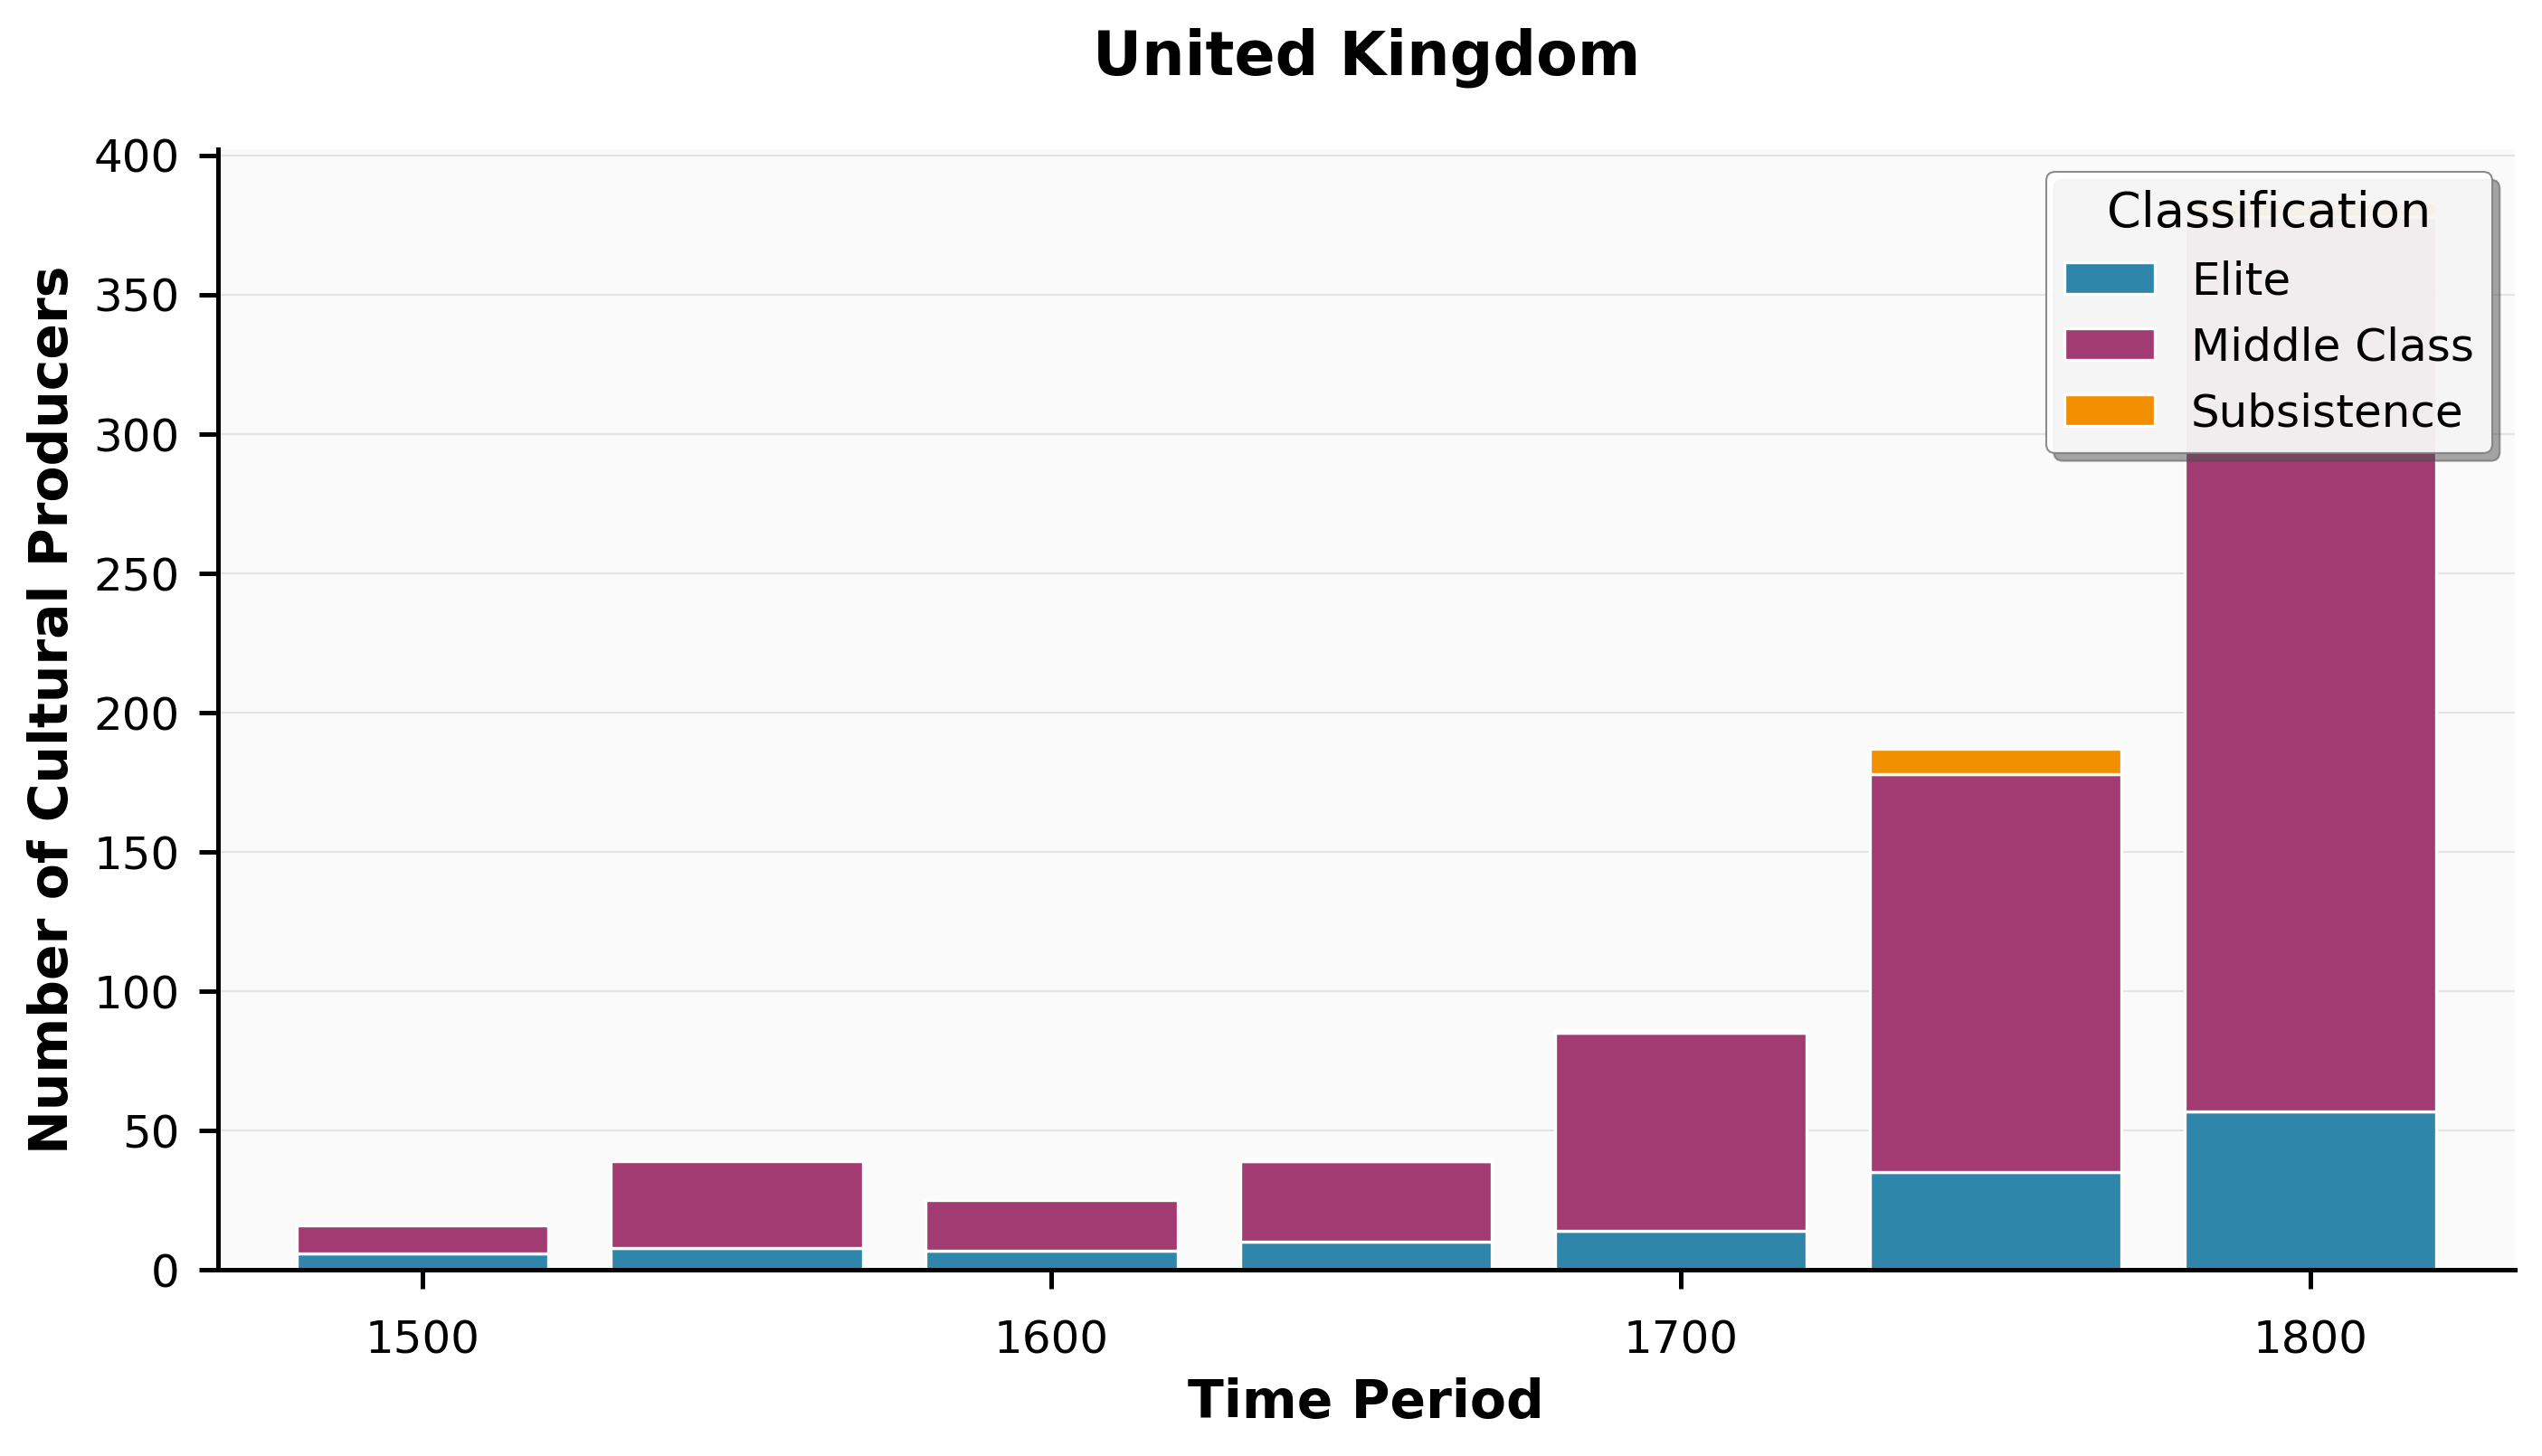

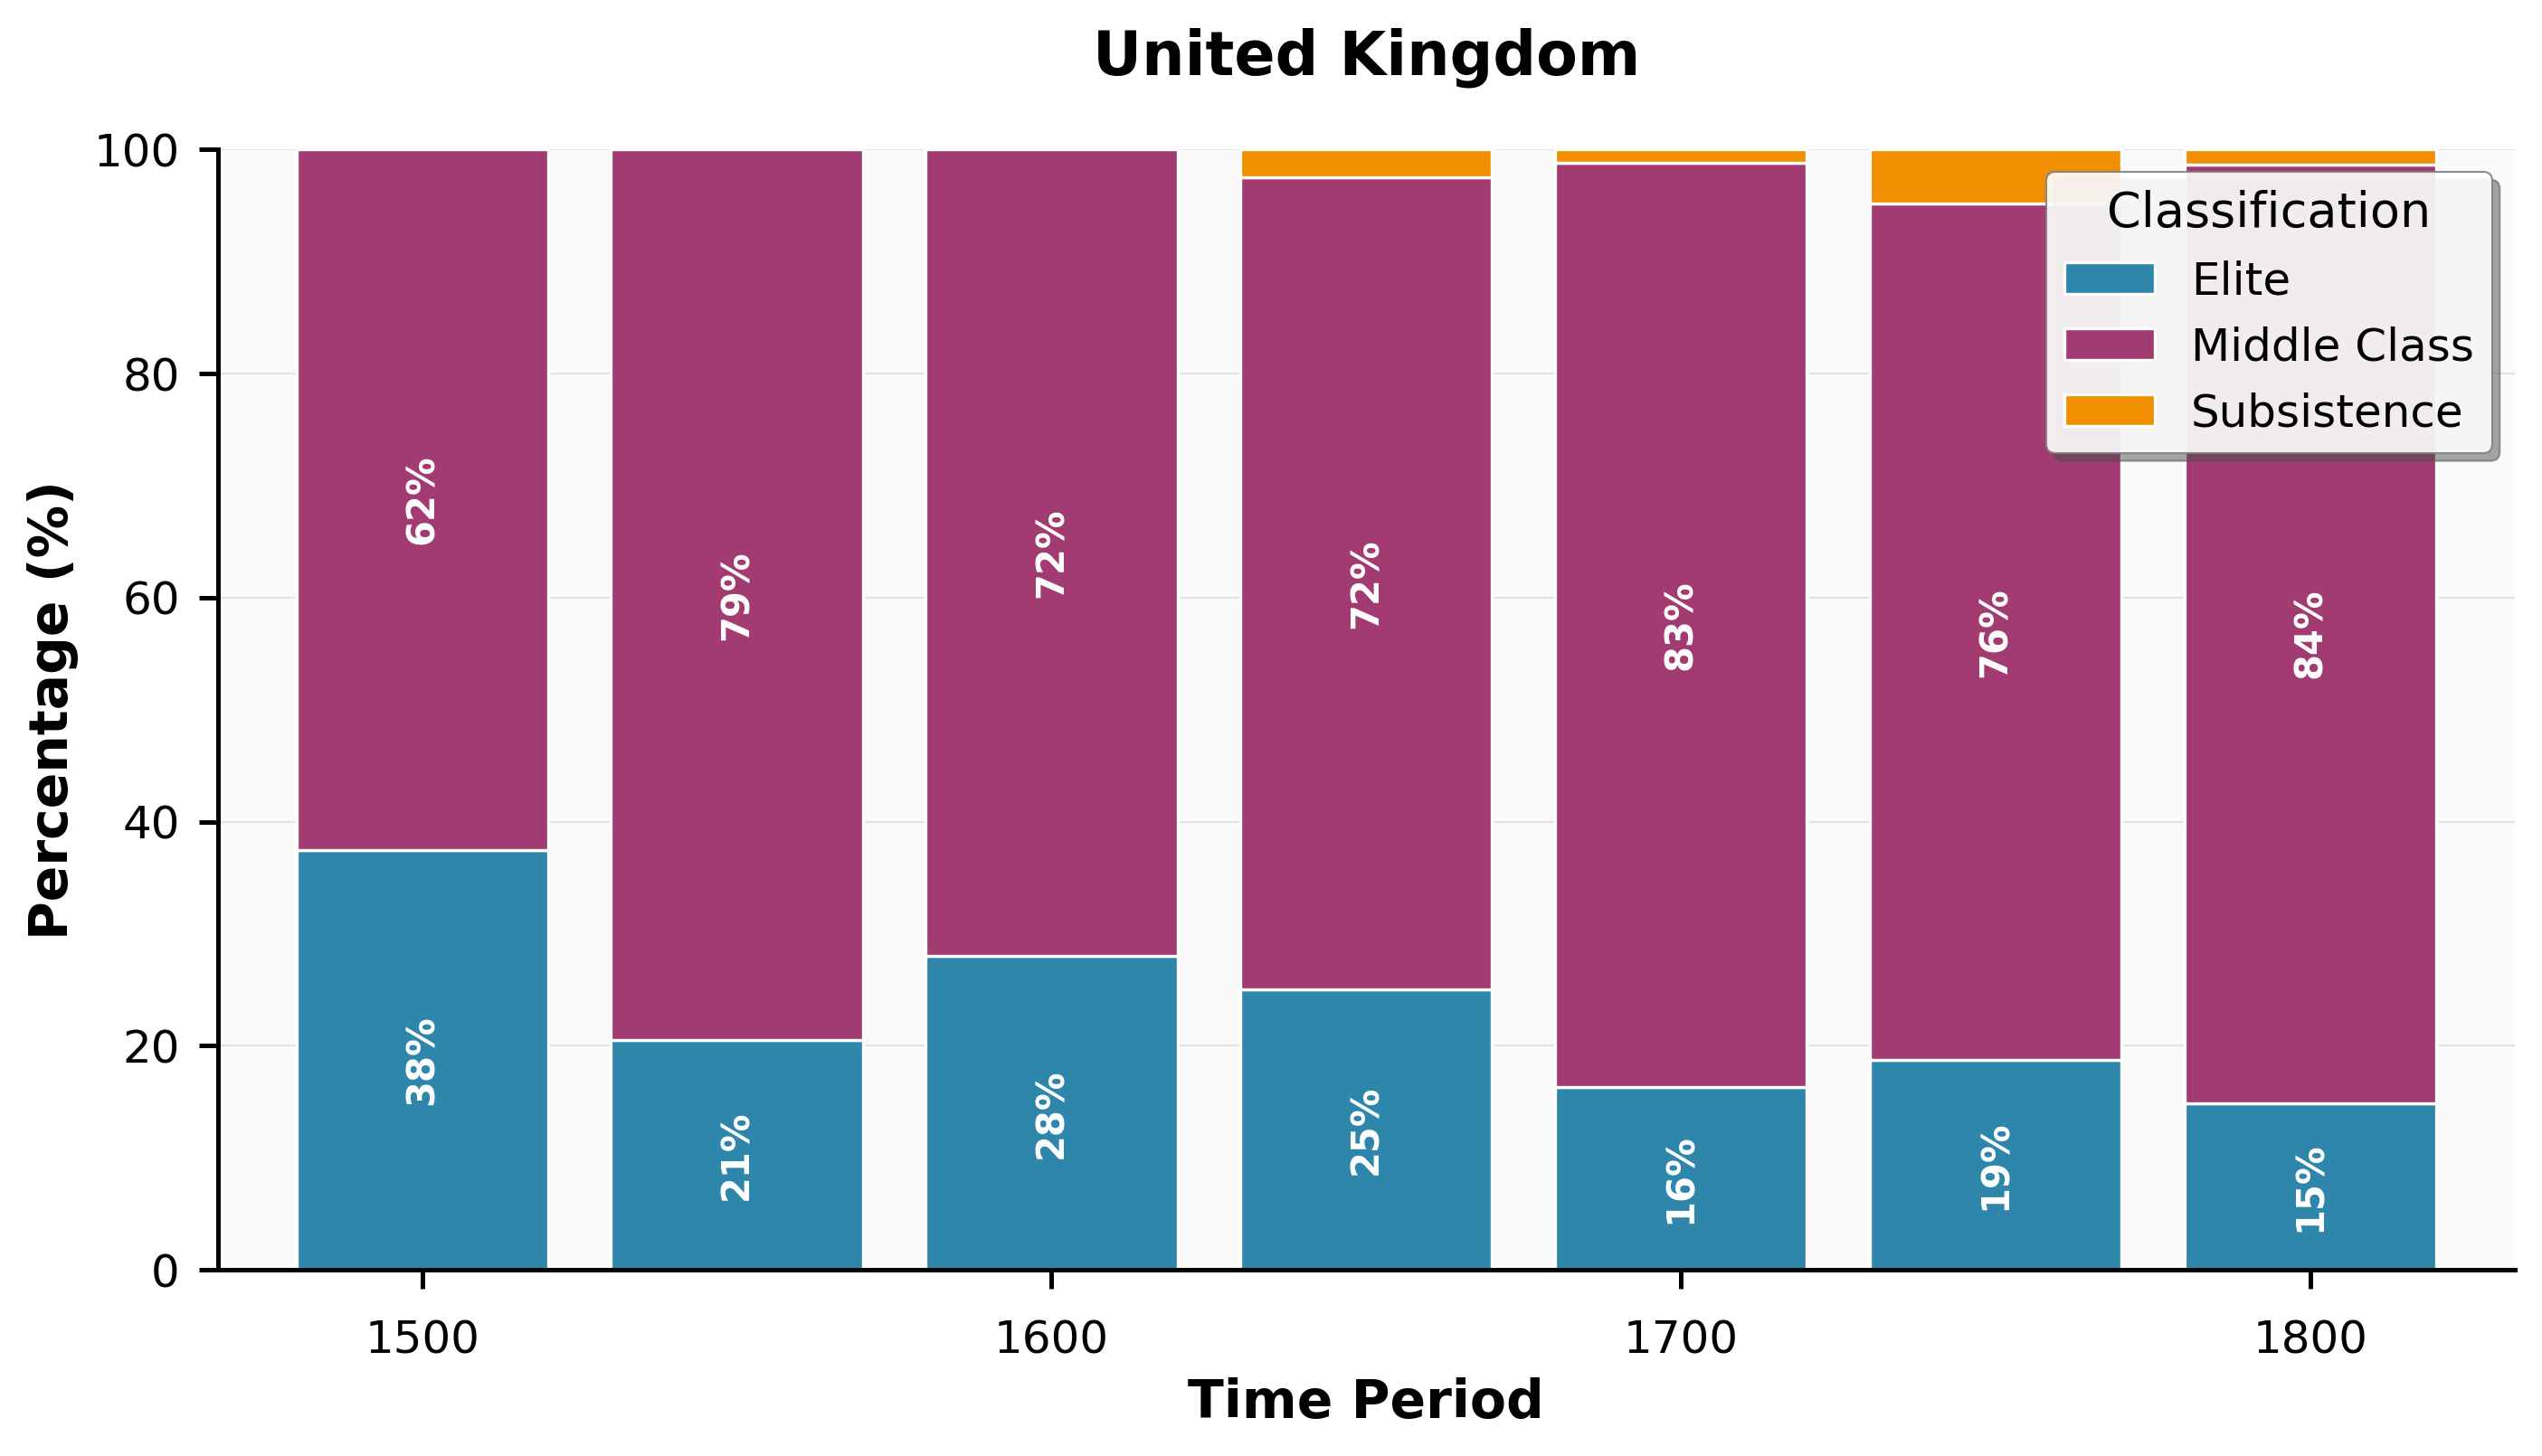

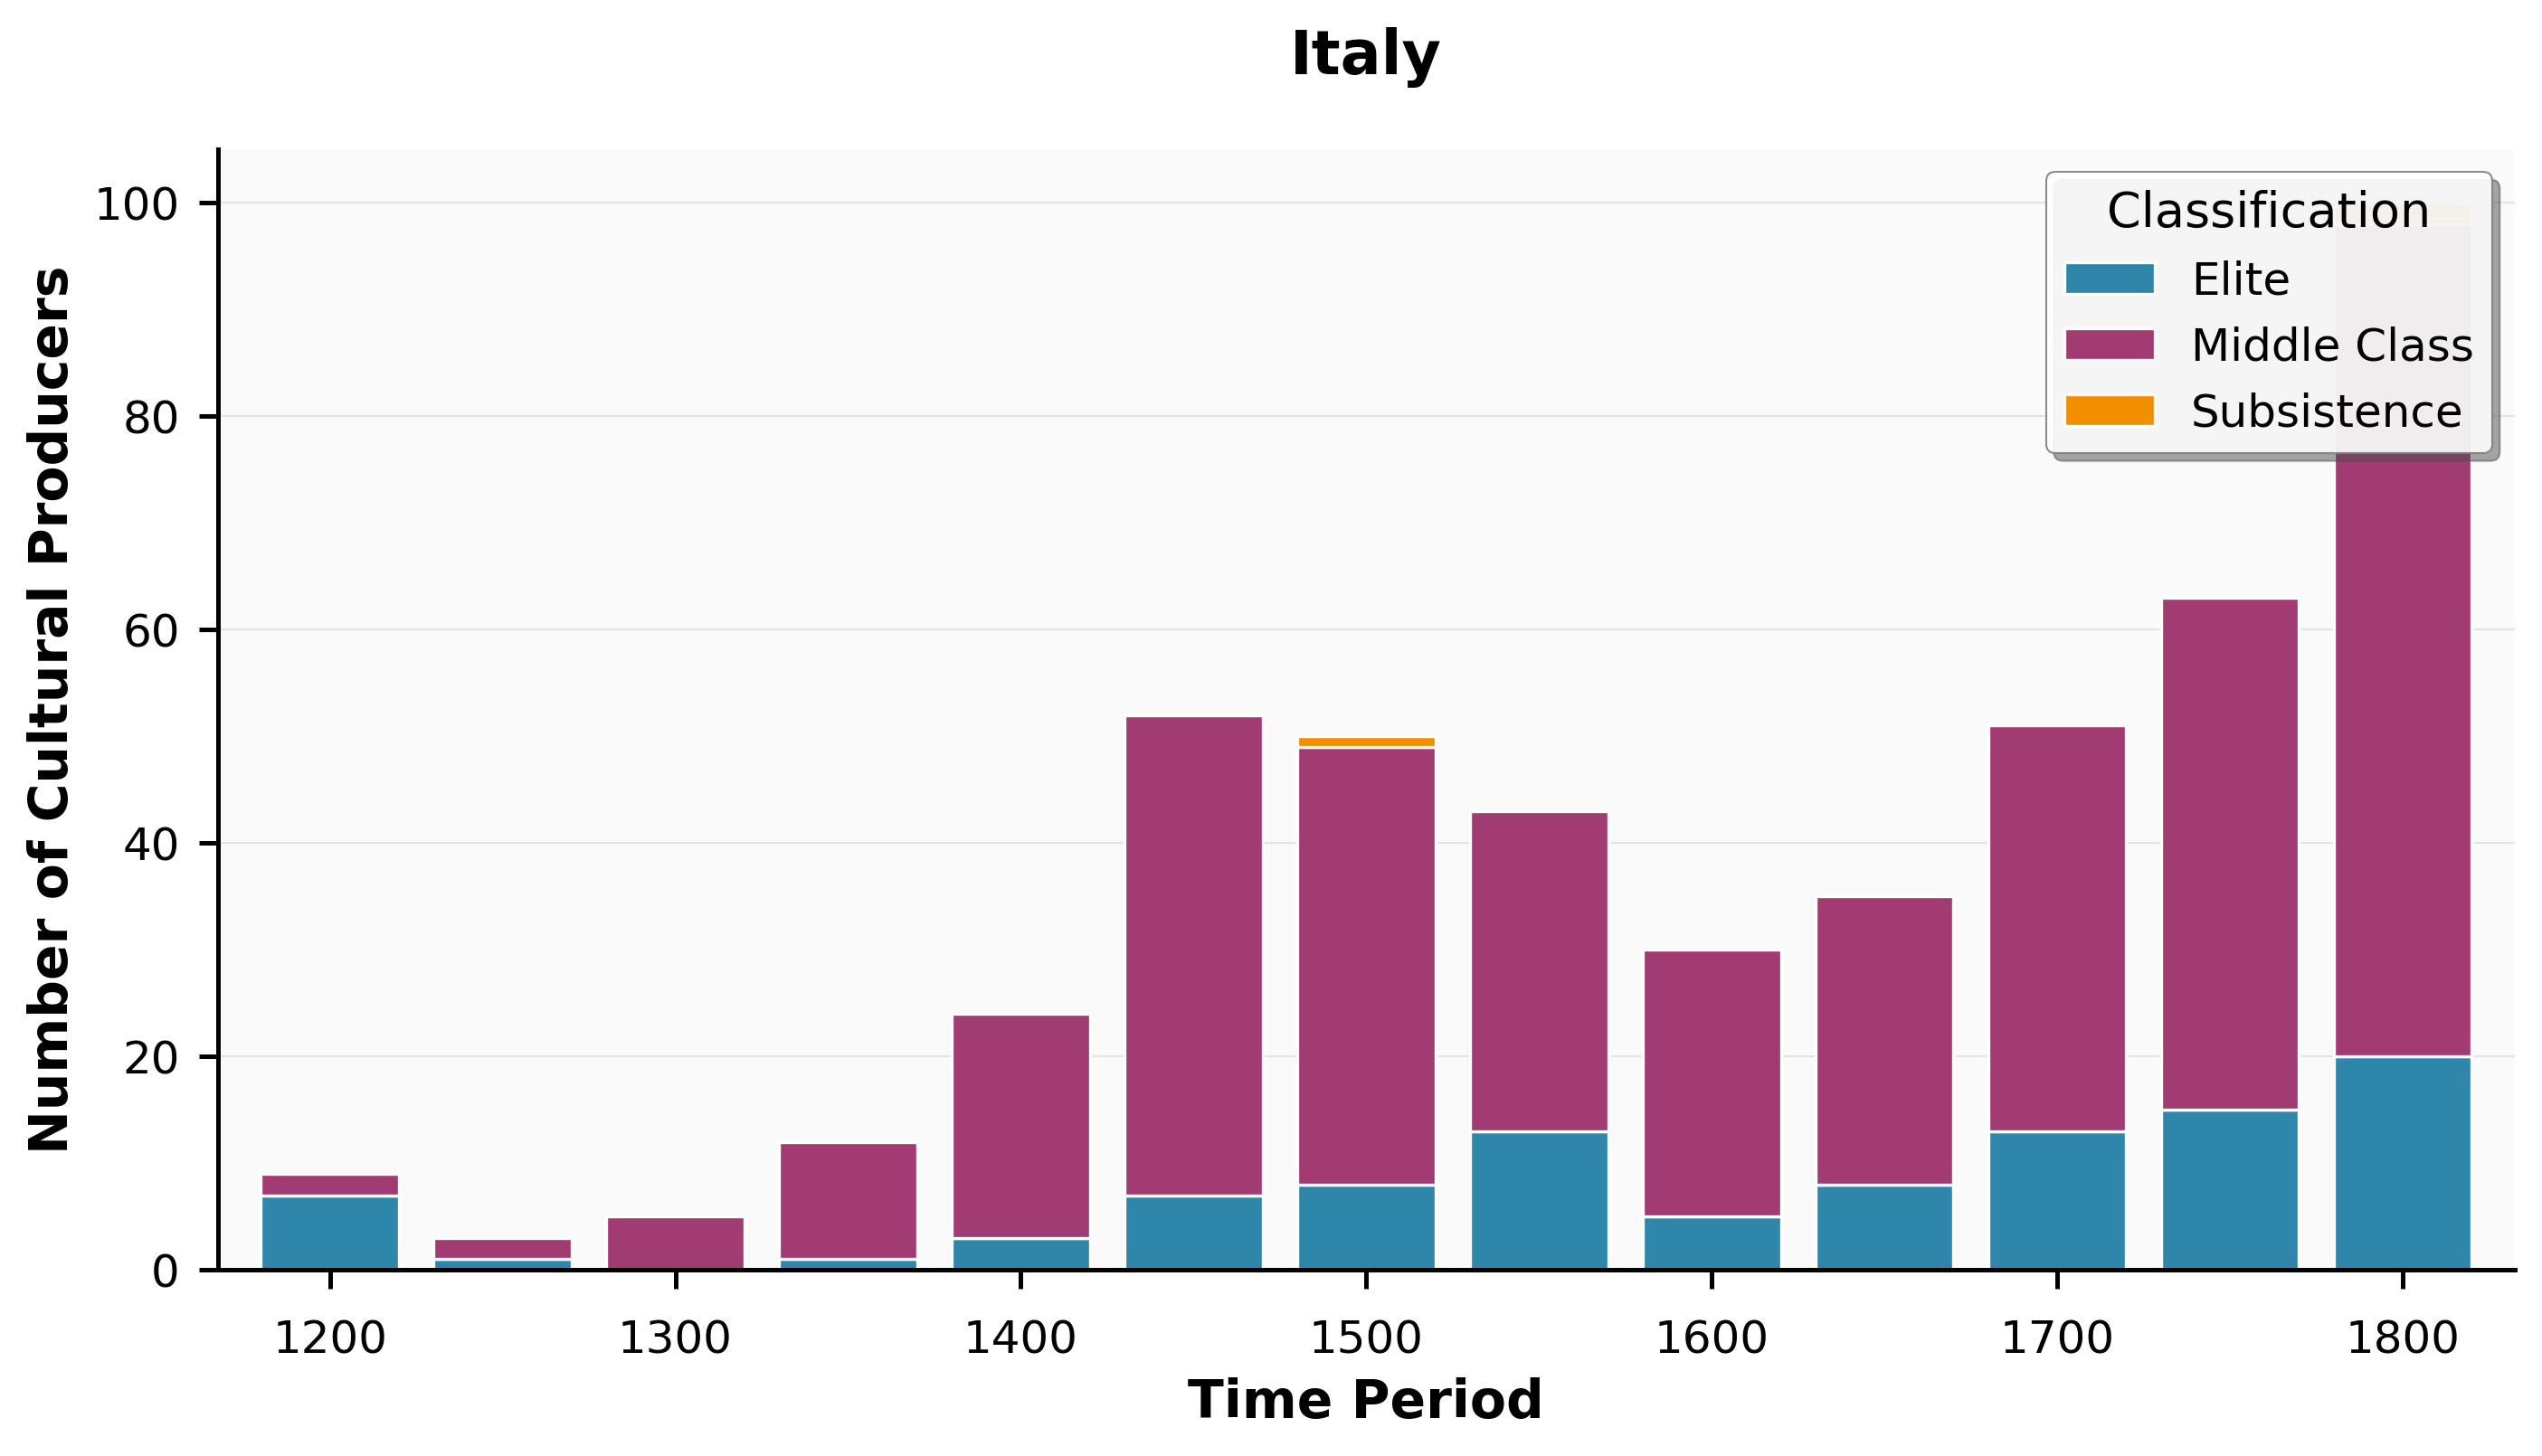

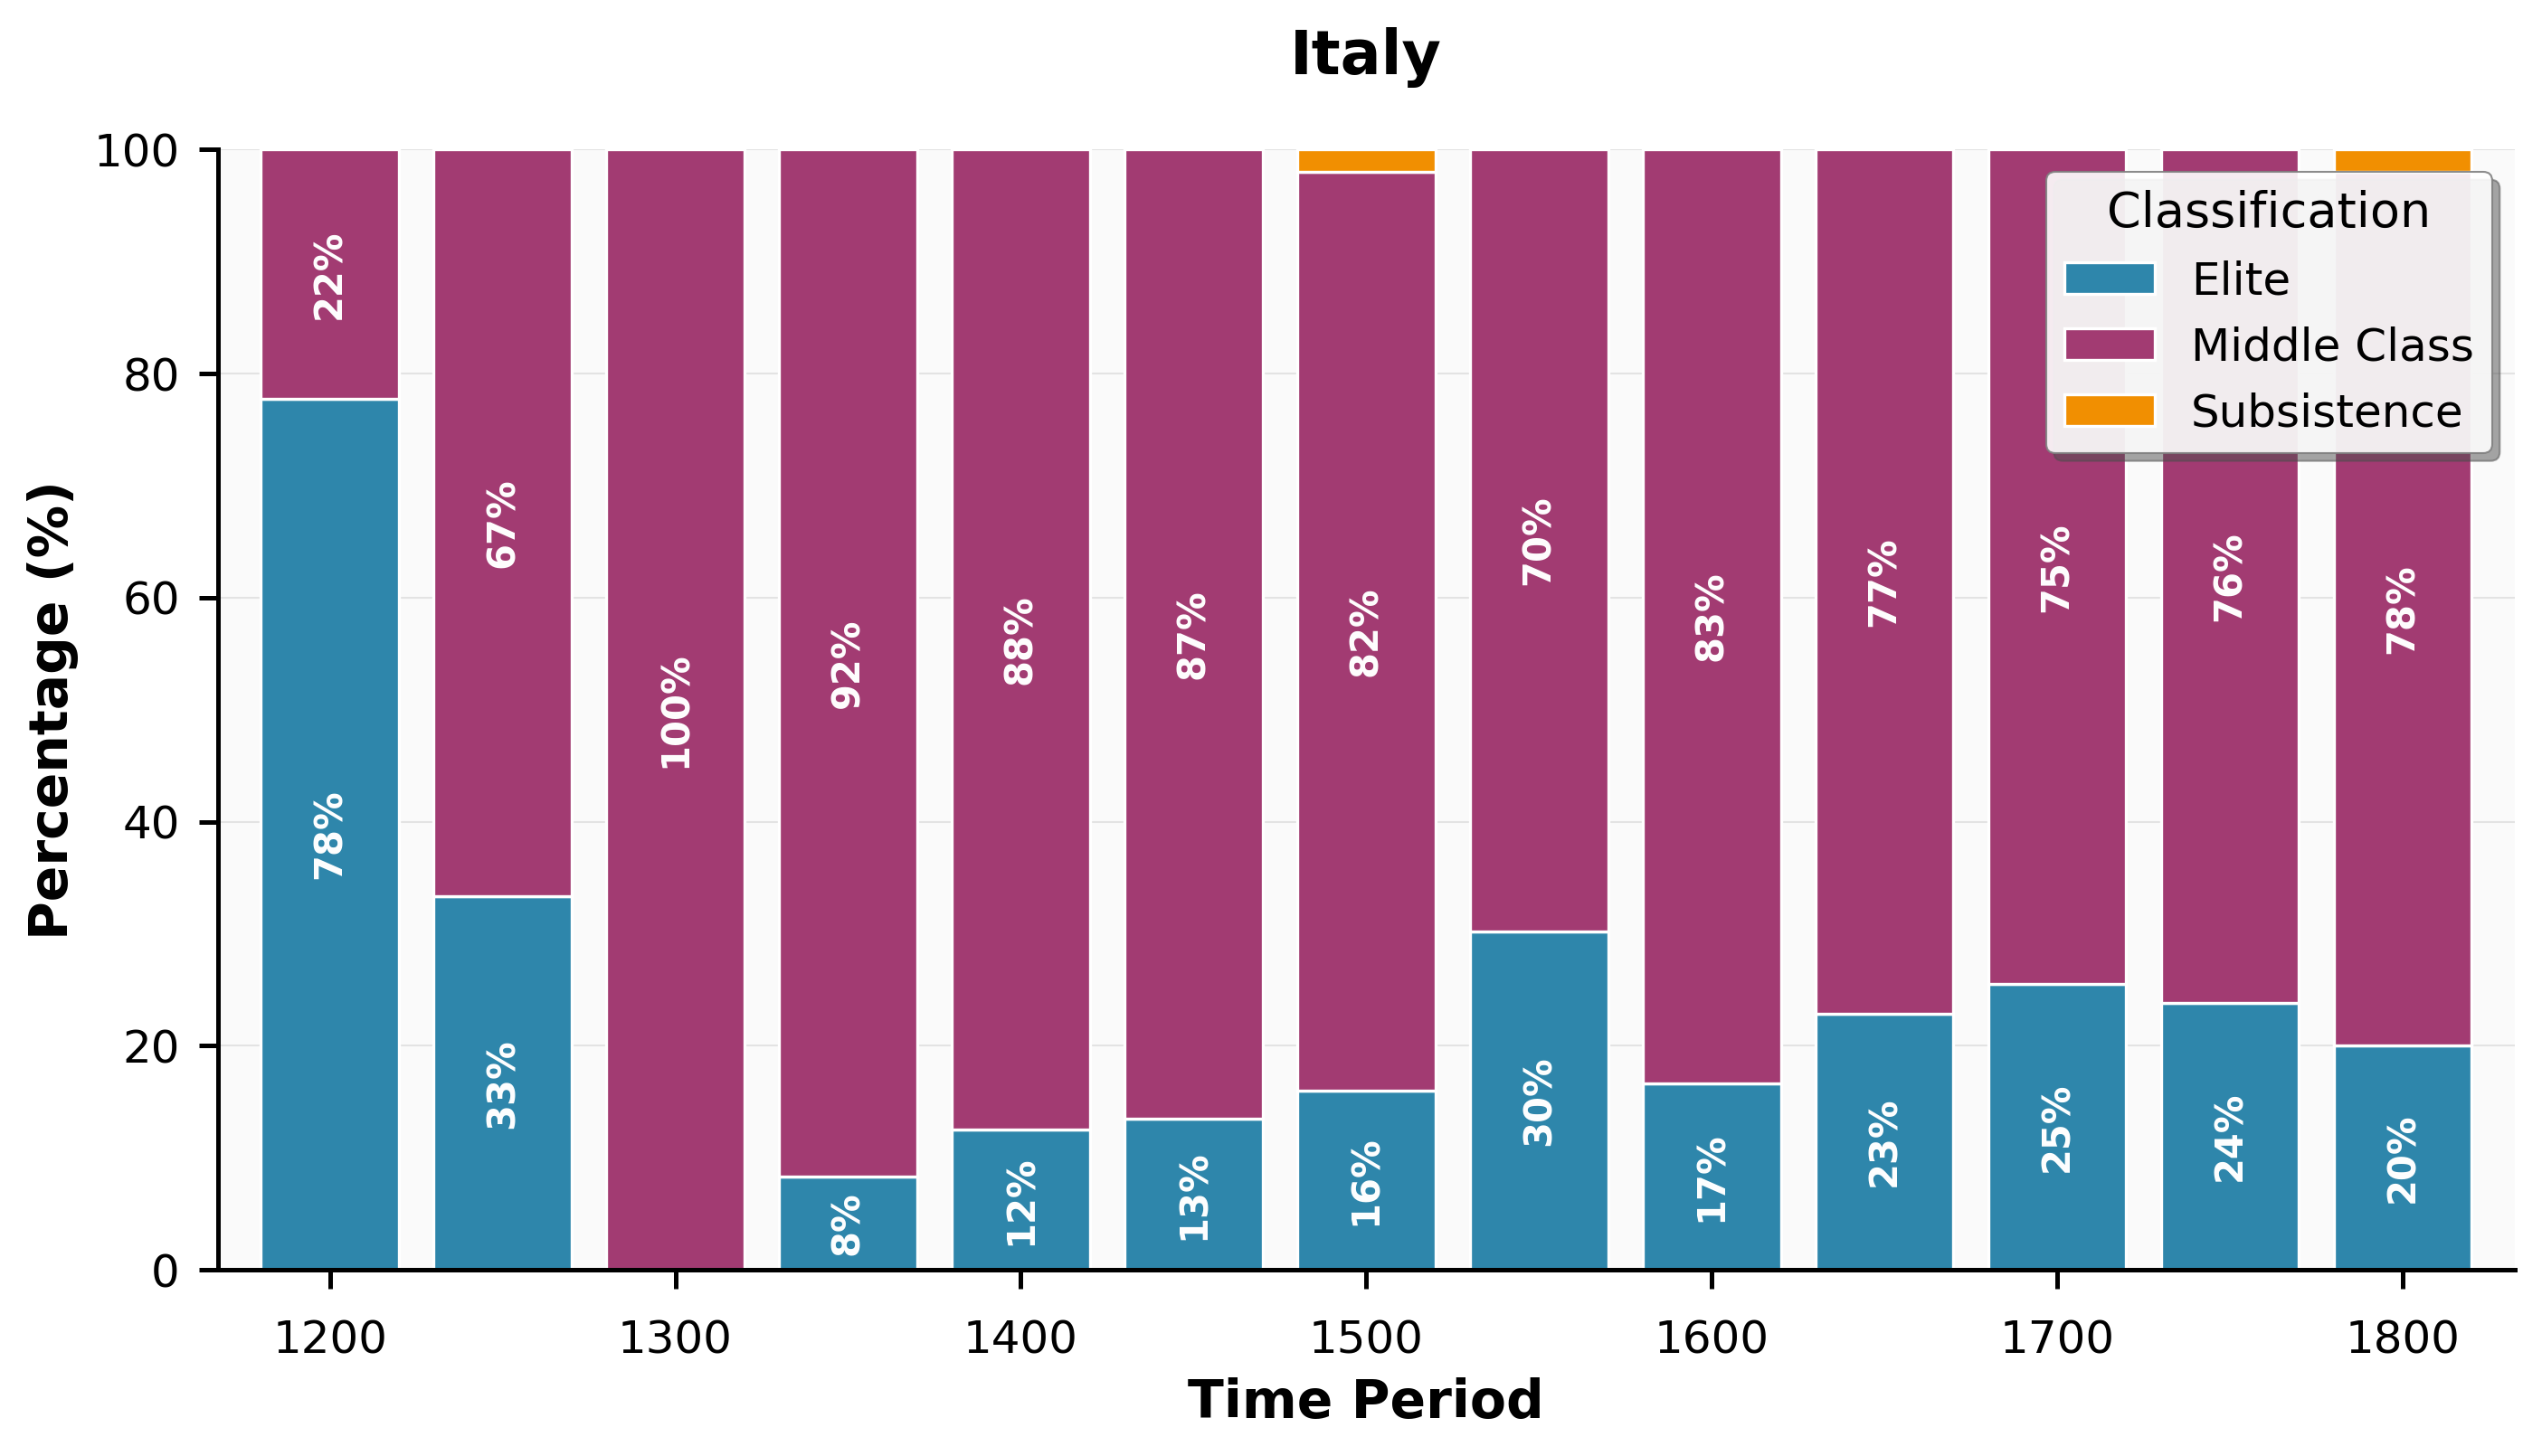

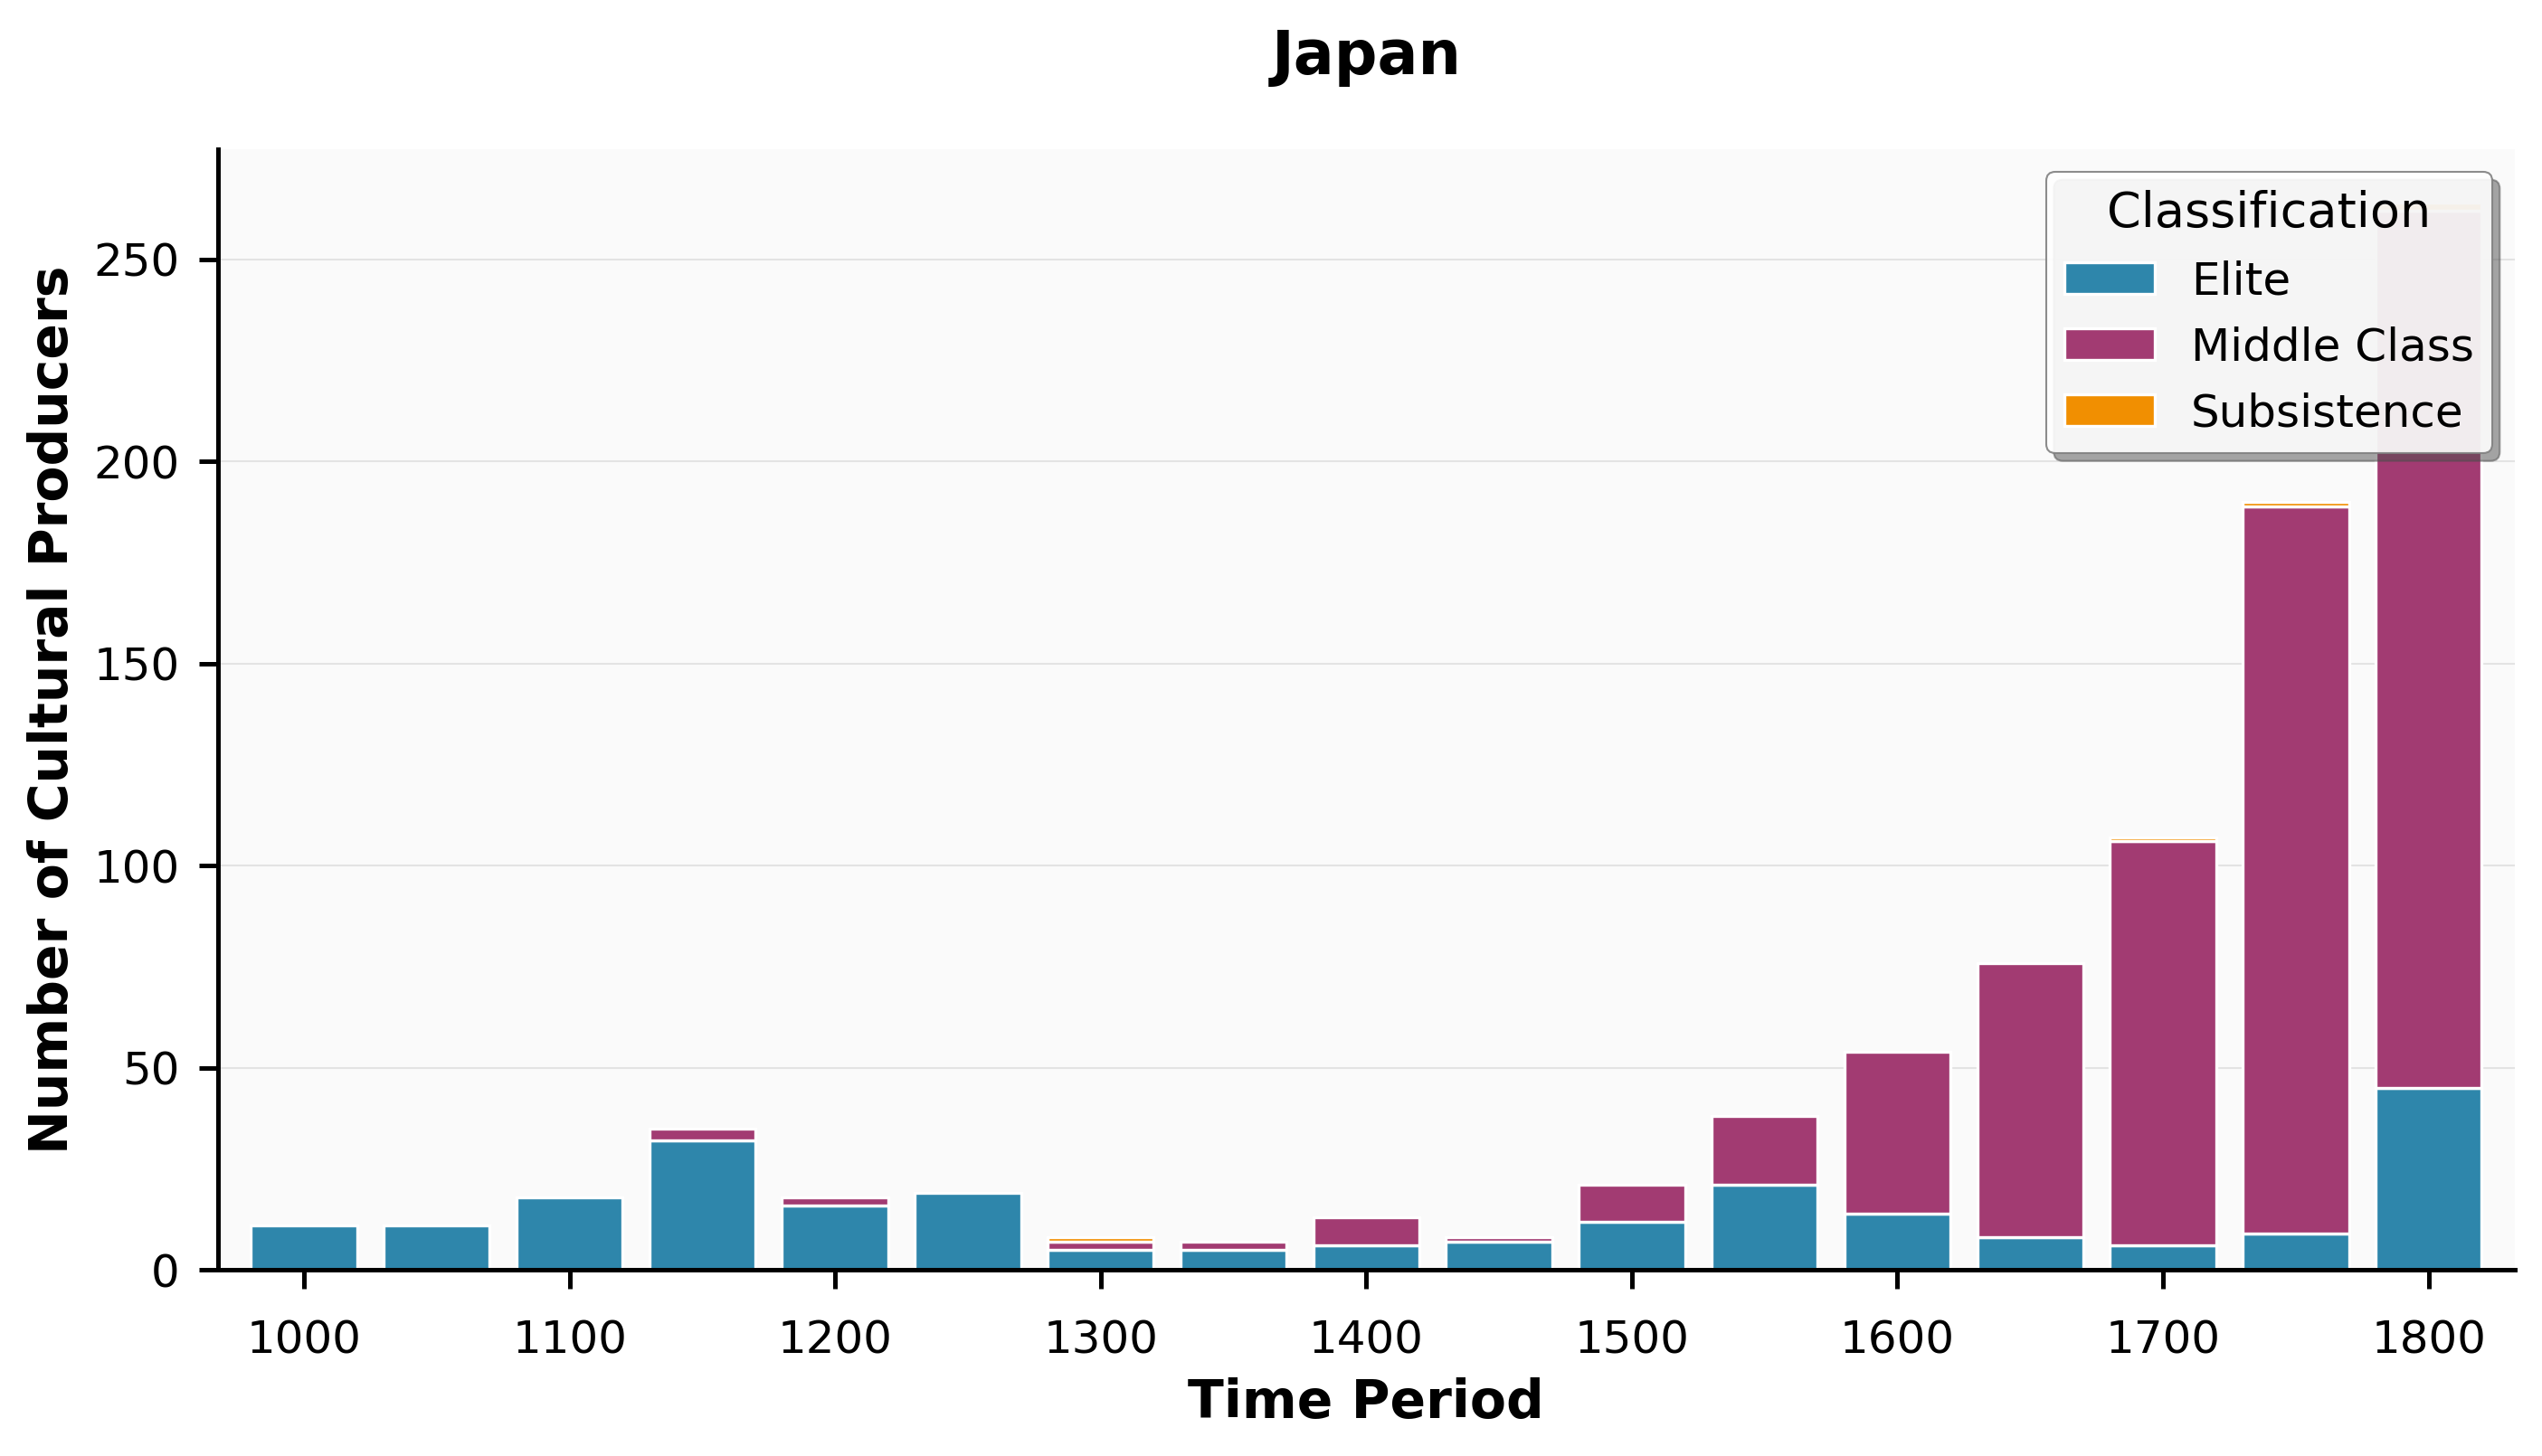

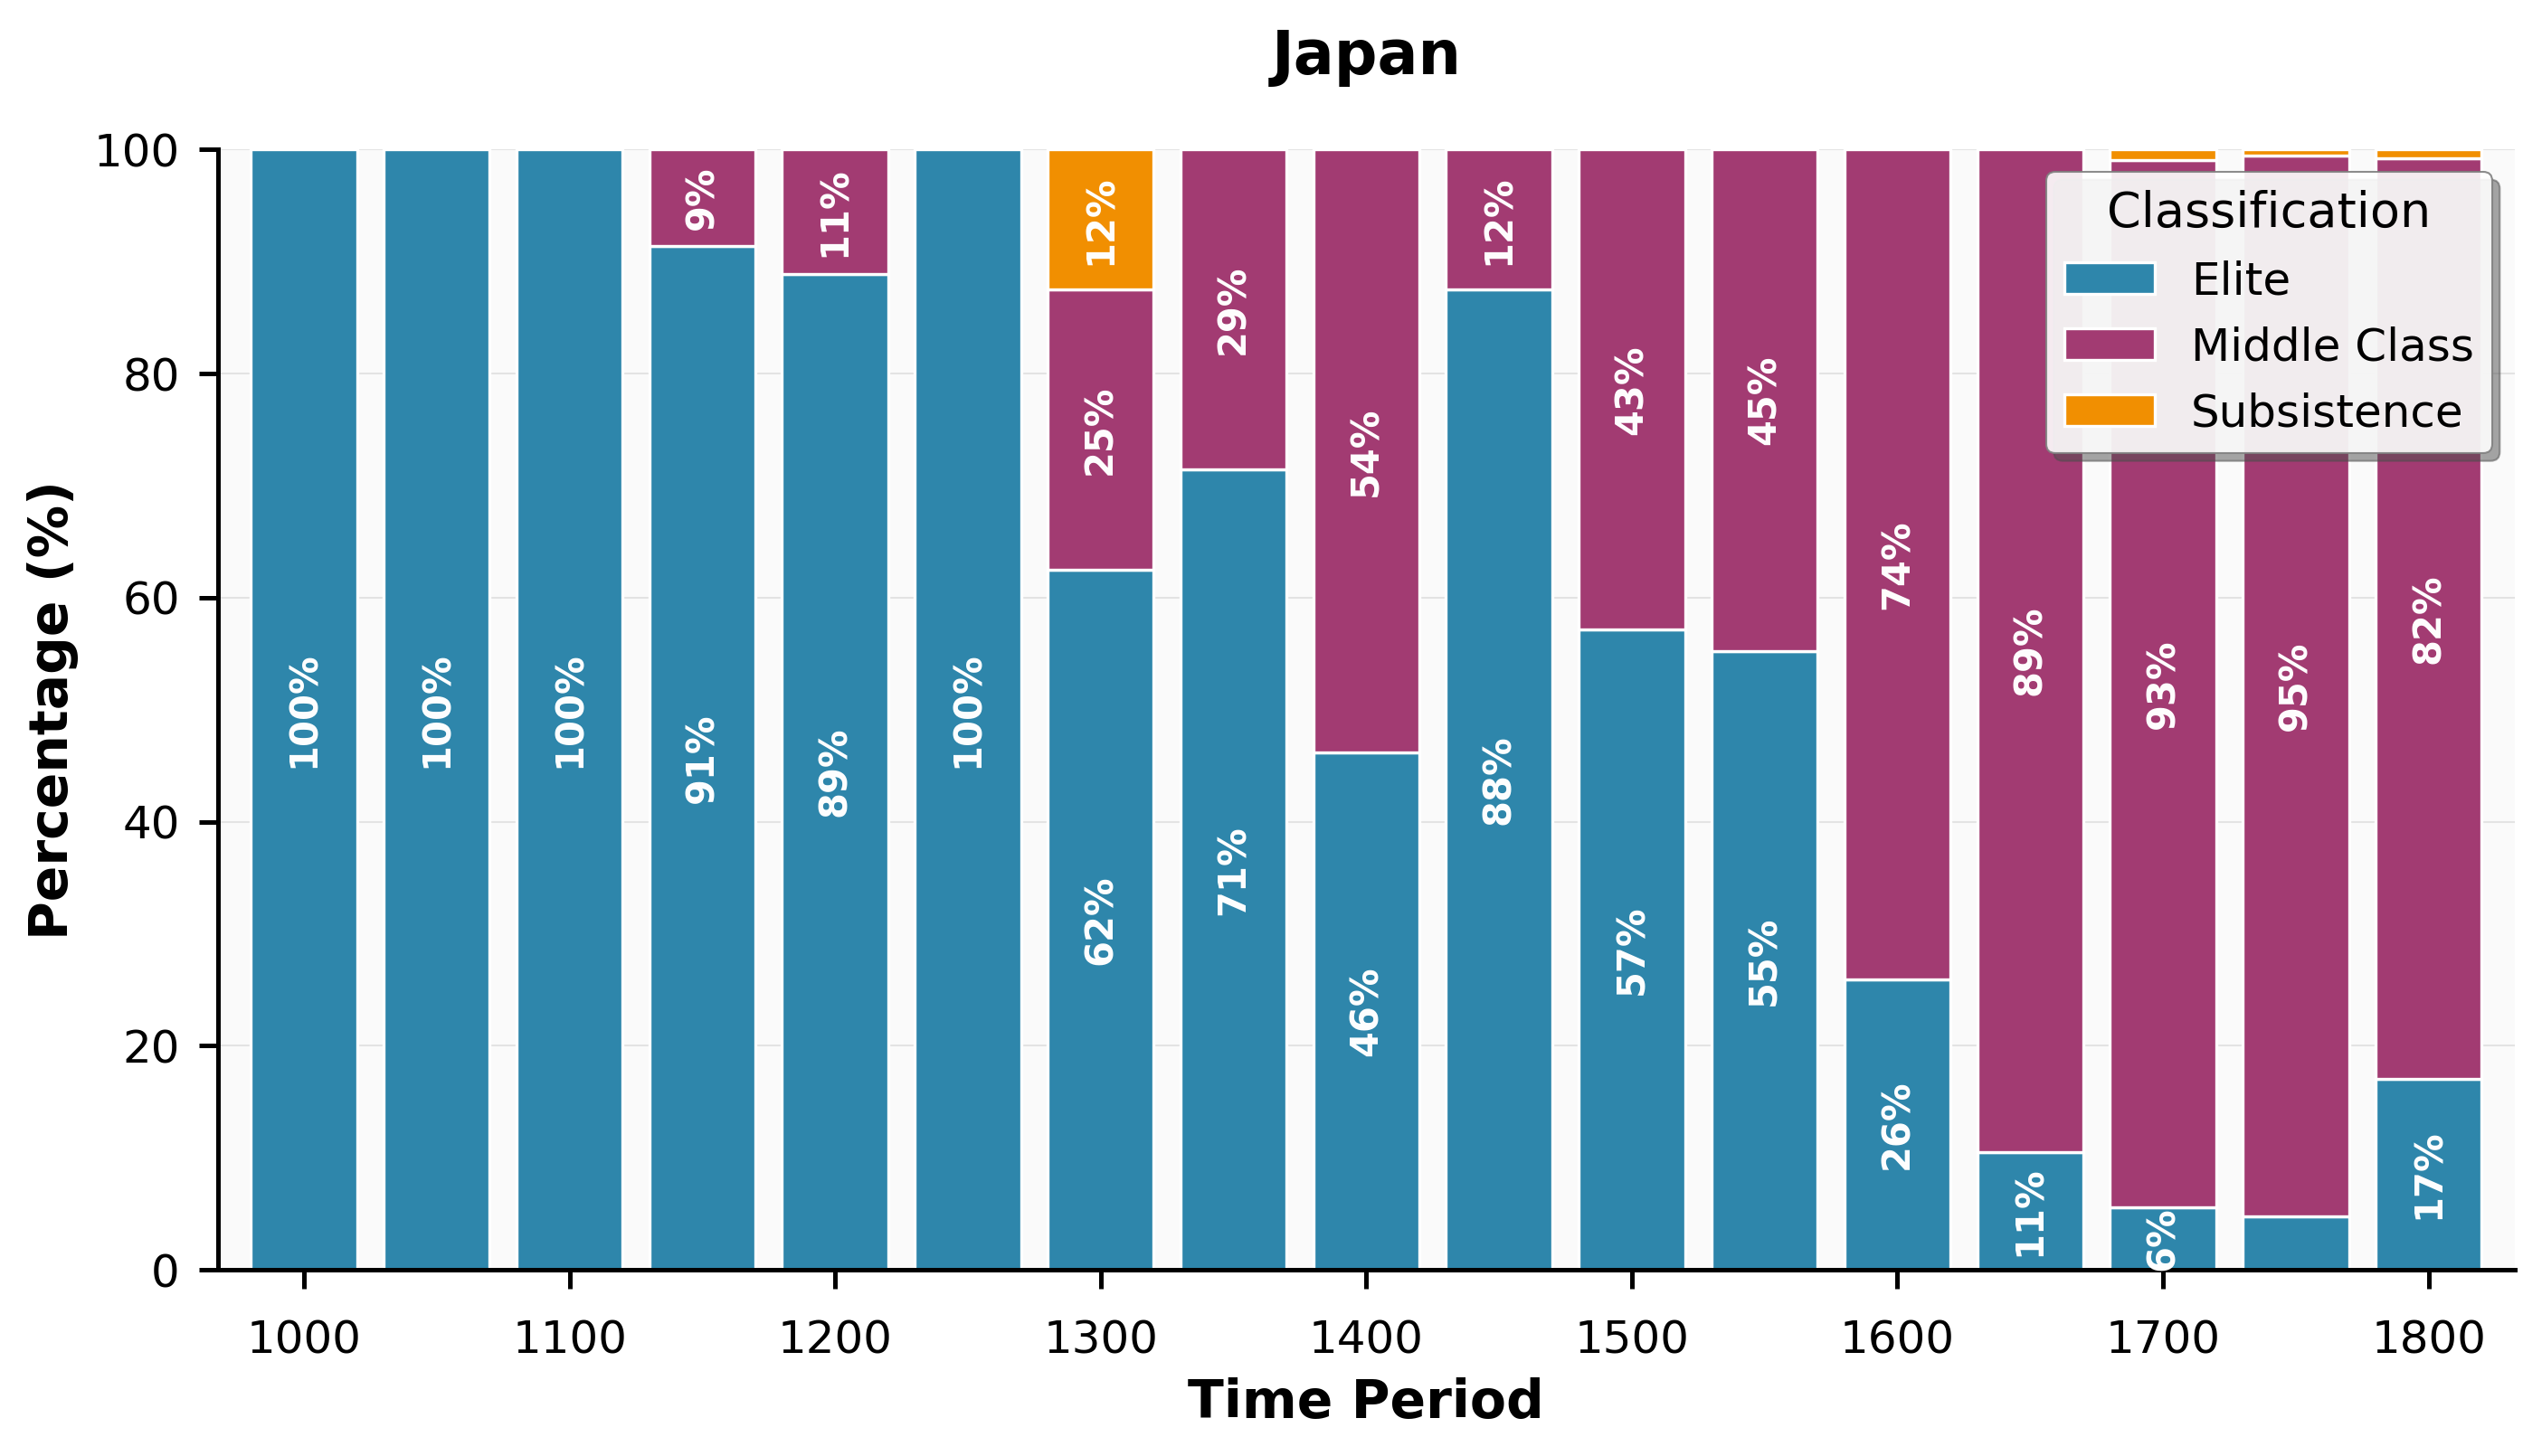

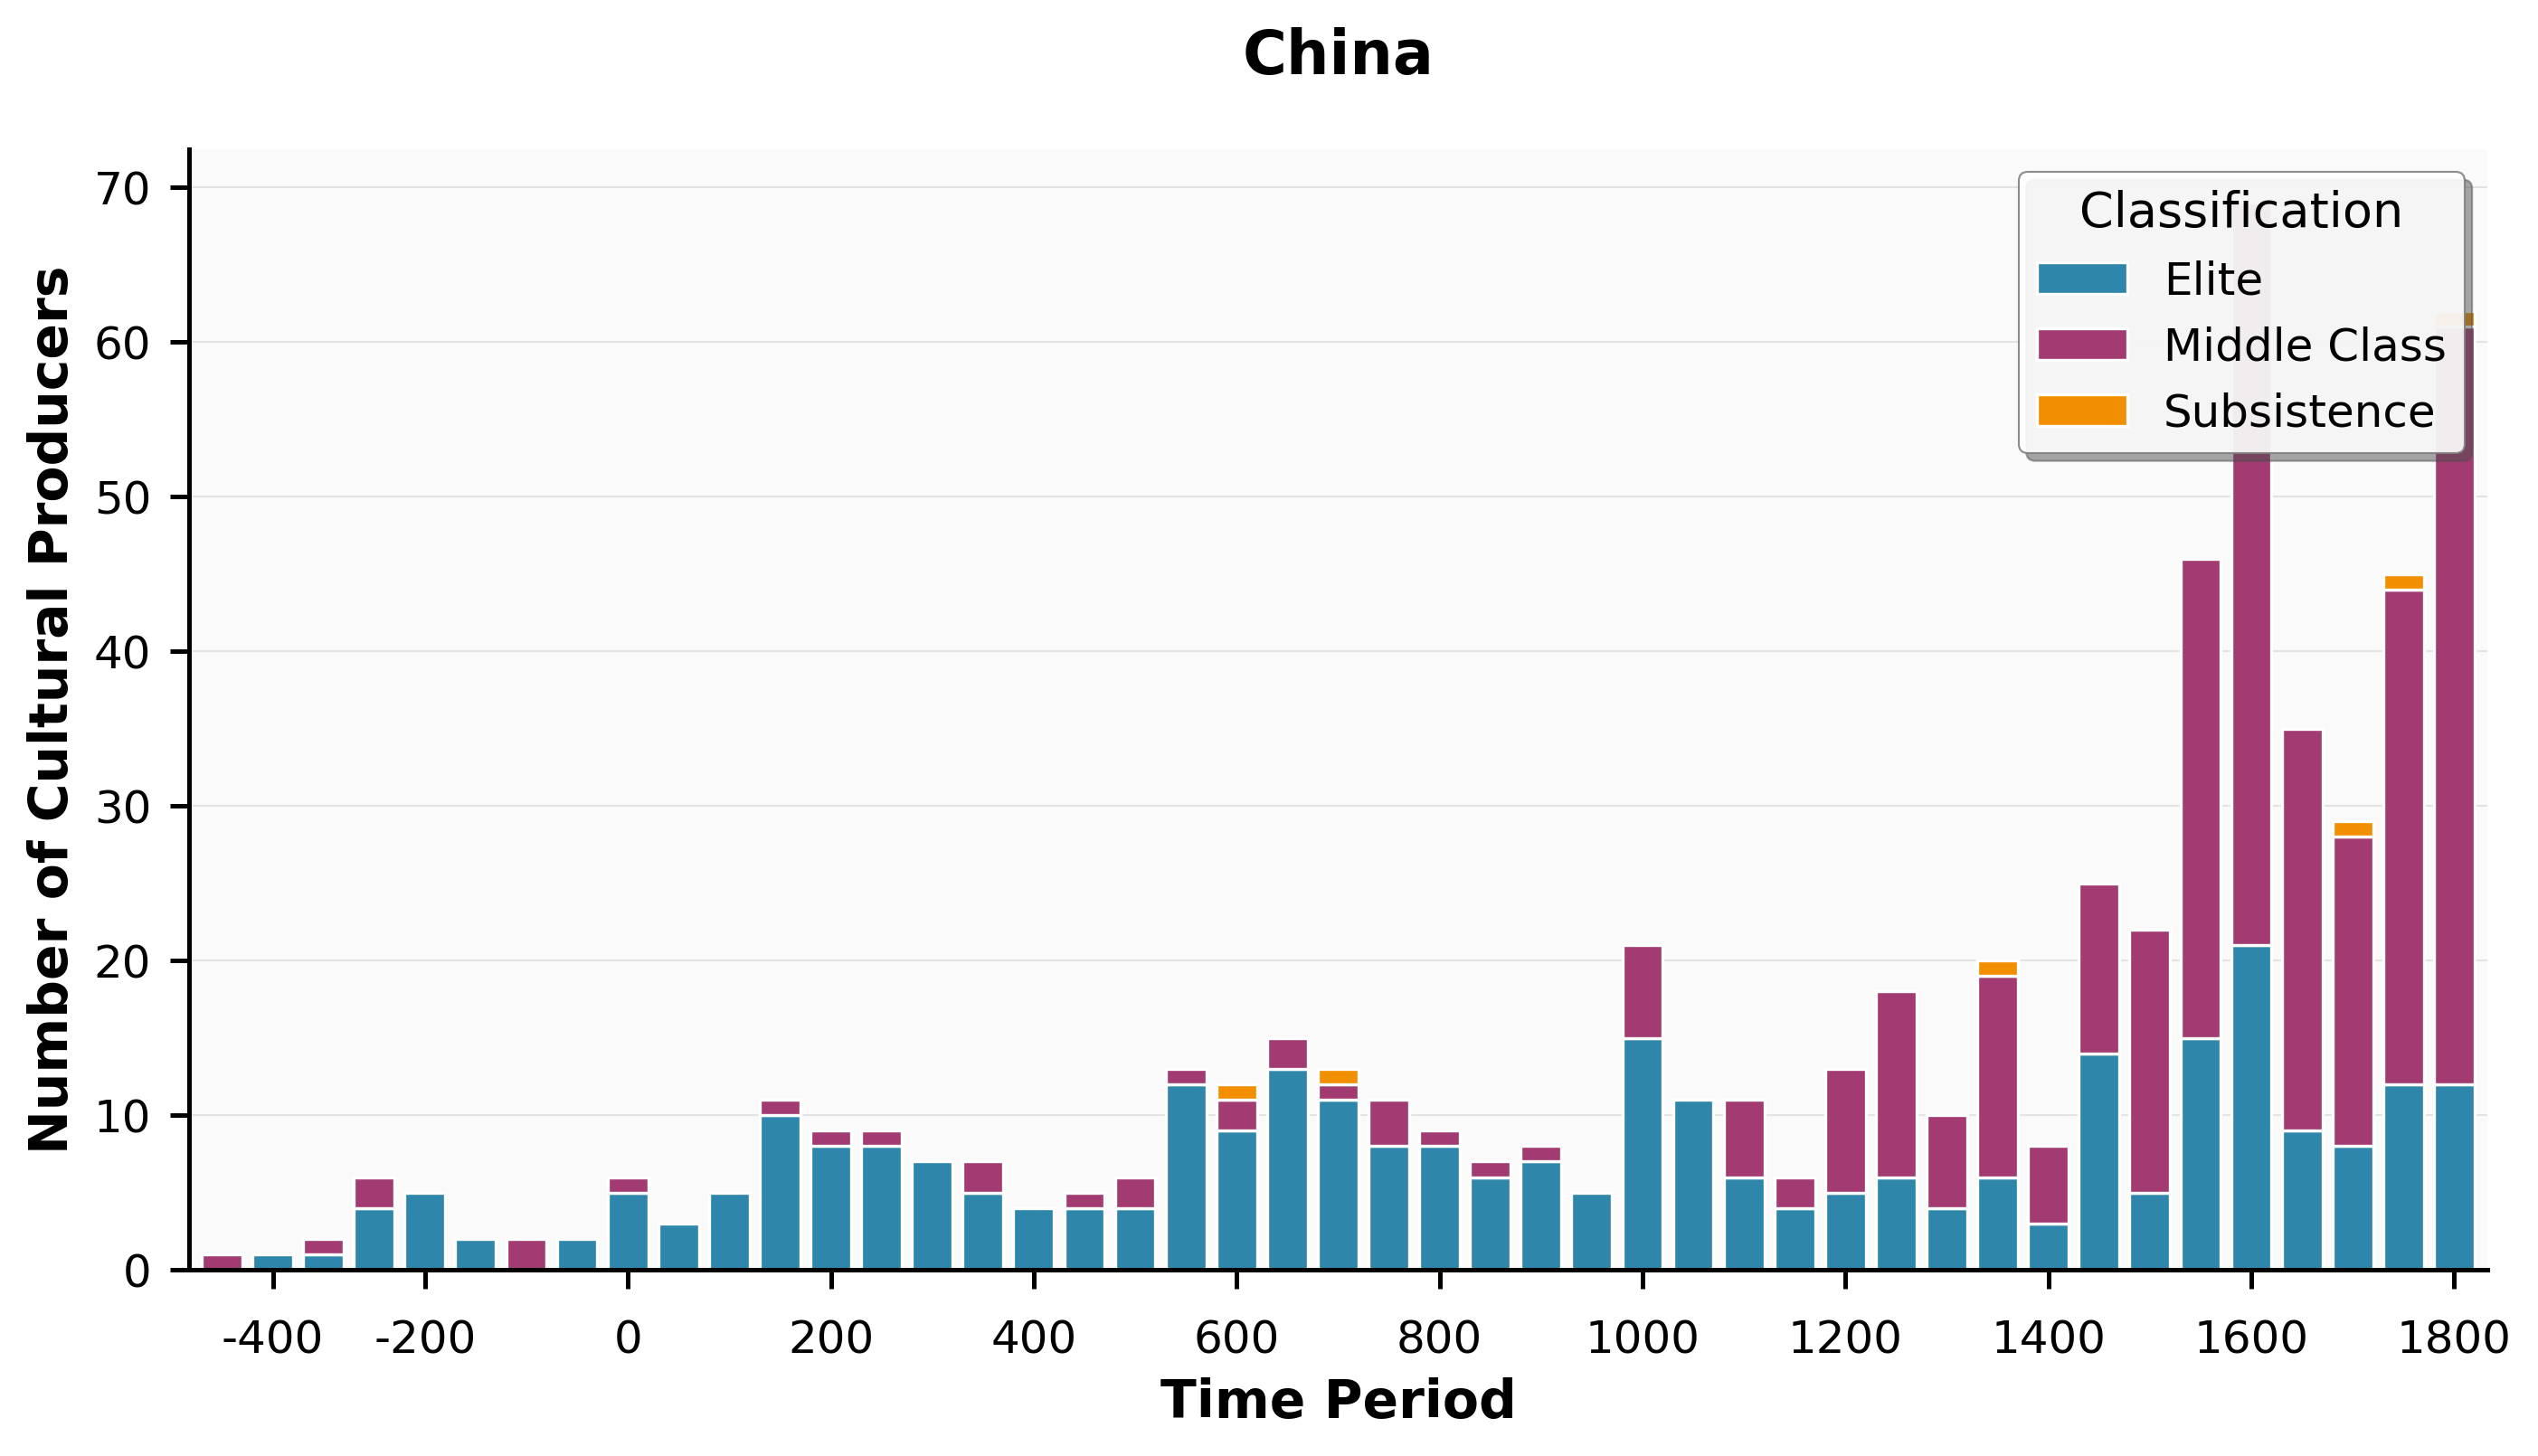

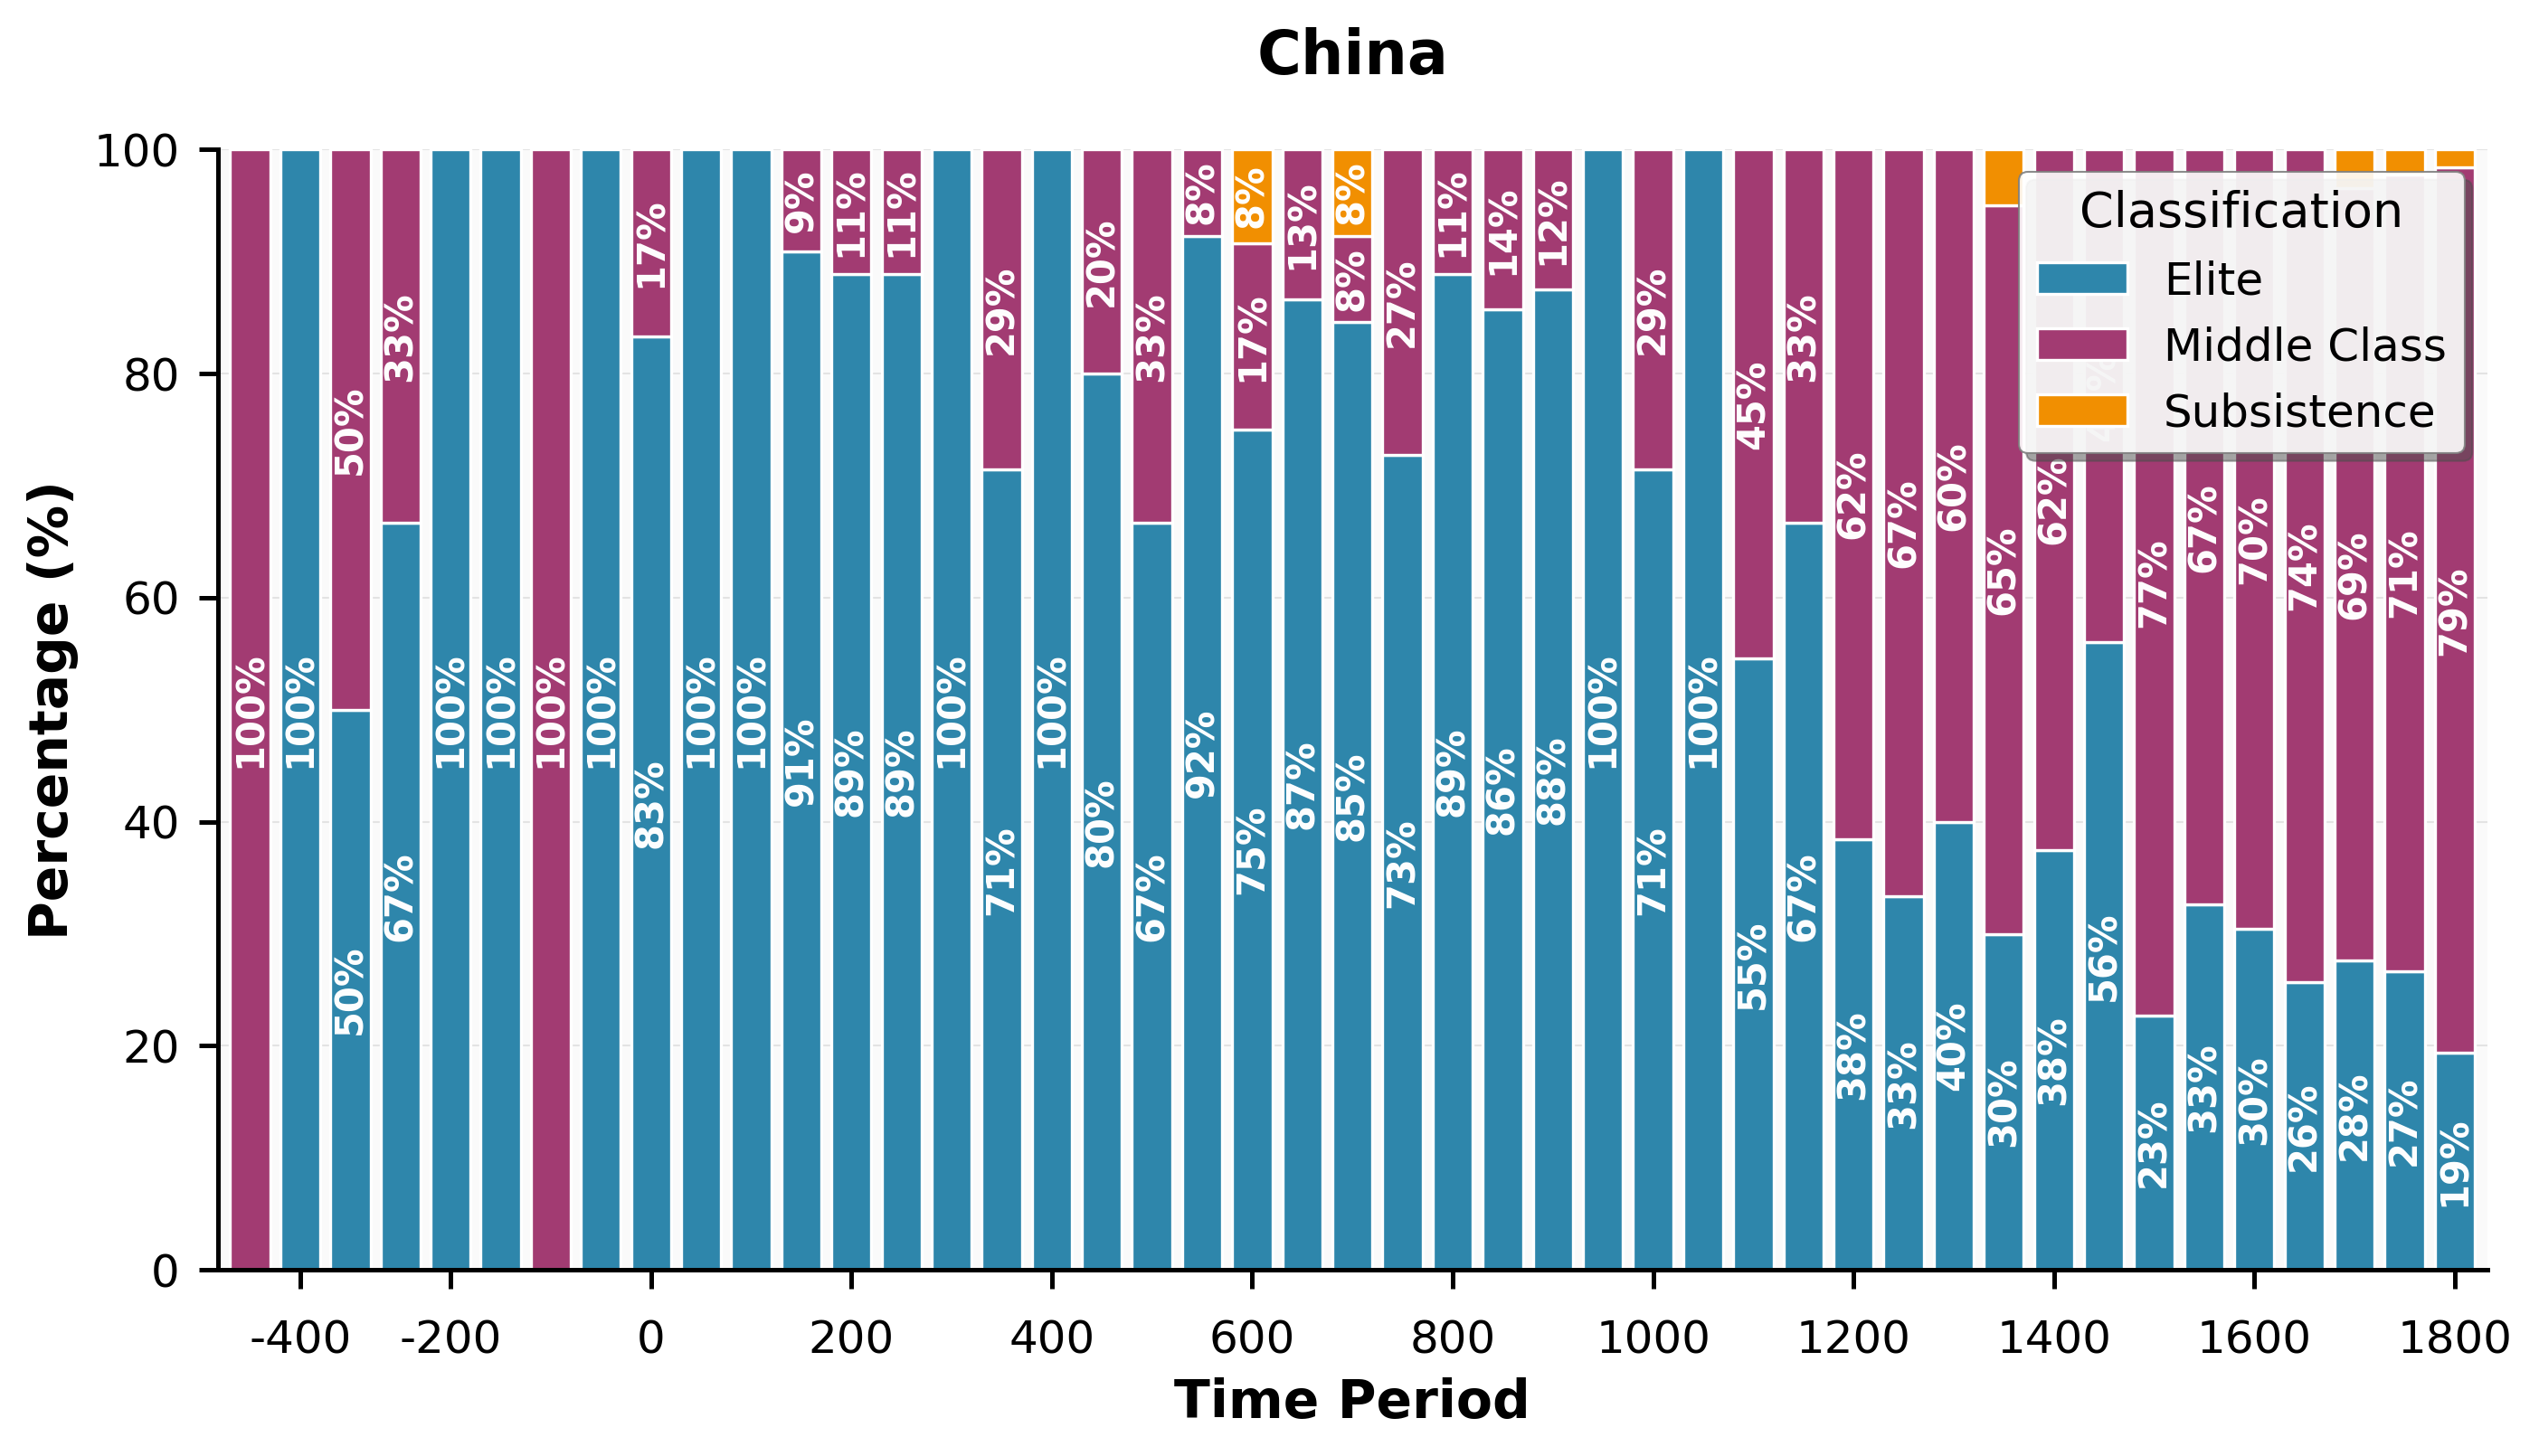

In [9]:

regions = ['United Kingdom', 'Italy', 'Japan', 'China']



for name in regions:

    df_test = df_fig[df_fig['region_name']==name]
    df_test = df_test.dropna()
    df_test['period'] = (df_test['birthyear'] // 50) * 50

    df_test = df_test[df_test['period']<1850]
    plot_normalized_classification(df_test, region_name=name, normalize=False,  figsize=(10, 6))

    plot_normalized_classification(df_test, region_name=name, normalize=True,  figsize=(10, 6))


## Stats

In [10]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

path = '../3-unseen_species_index/unseen_species_model/unseen_species_model_bayesian.csv'

df_cultura = pd.read_csv(path, index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2'] # plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})




df_social = pd.read_csv('data/social_origins/final_sample_2.csv', index_col = [0])
df_info = pd.read_csv('../2-cultura_database_extract/db_extract/df_individuals_score.csv')
df_info = df_info[['individual_wikidata_id', 'decade']].drop_duplicates()
df_social_final = pd.merge(df_info, df_social, on = 'individual_wikidata_id')

dict_regions = {'China':'Chinese world'}

df_social_final['region_name'] = df_social_final['region_name'].apply(lambda x : dict_regions.get(x, x))
df_social_final = df_social_final.dropna()


# Creating a new column to identify non-elite rows (everything except 'Elite')

df_social_final['non_elite'] = df_social_final['classification'] != 'Elite'
df_social_final

    # Grouping by region_name AND decade, then counting non-elite entries
region_decade_counts = df_social_final.groupby(['region_name', 'decade'])['non_elite'].sum().reset_index()


# Calculate total counts per region and decade
region_decade_totals = df_social_final.groupby(['region_name', 'decade']).size().reset_index(name='total')


# Merge counts with totals
result_df = region_decade_counts.merge(region_decade_totals, on=['region_name', 'decade'])

 # Calculate percentage of non-elite entries
result_df['percentage_non_elite'] = (result_df['non_elite'] / result_df['total']) * 100


# Filter to include only groups with more than 5 entries
result_df = result_df[result_df['total'] > 5]

df_final = pd.merge(result_df, df_cultura, on = ['region_name', 'decade'])


df_final = df_final[['region_name', 'decade', 'percentage_non_elite', 'N_est', 'total']].copy()
df_final = df_final.rename(columns={'total':'total_n'})
df_final = df_final[df_final['decade']<=1840]
df_final.to_csv('data/social_origins/final_sample_2_cpm.csv')


df_final


,region_name,decade,percentage_non_elite,N_est,total_n
0,Chinese world,730,16.666667,10.891210,6
1,Chinese world,1040,57.142857,11.539985,7
2,Chinese world,1340,66.666667,46.072392,6
3,Chinese world,1500,50.000000,73.256588,8
4,Chinese world,1510,33.333333,45.227454,6
...,...,...,...,...,...
119,United Kingdom,1800,73.529412,7343.164191,34
120,United Kingdom,1810,77.777778,6183.501728,36
121,United Kingdom,1820,90.625000,8466.536522,32
122,United Kingdom,1830,84.000000,7497.355052,50


## Relationship Graph

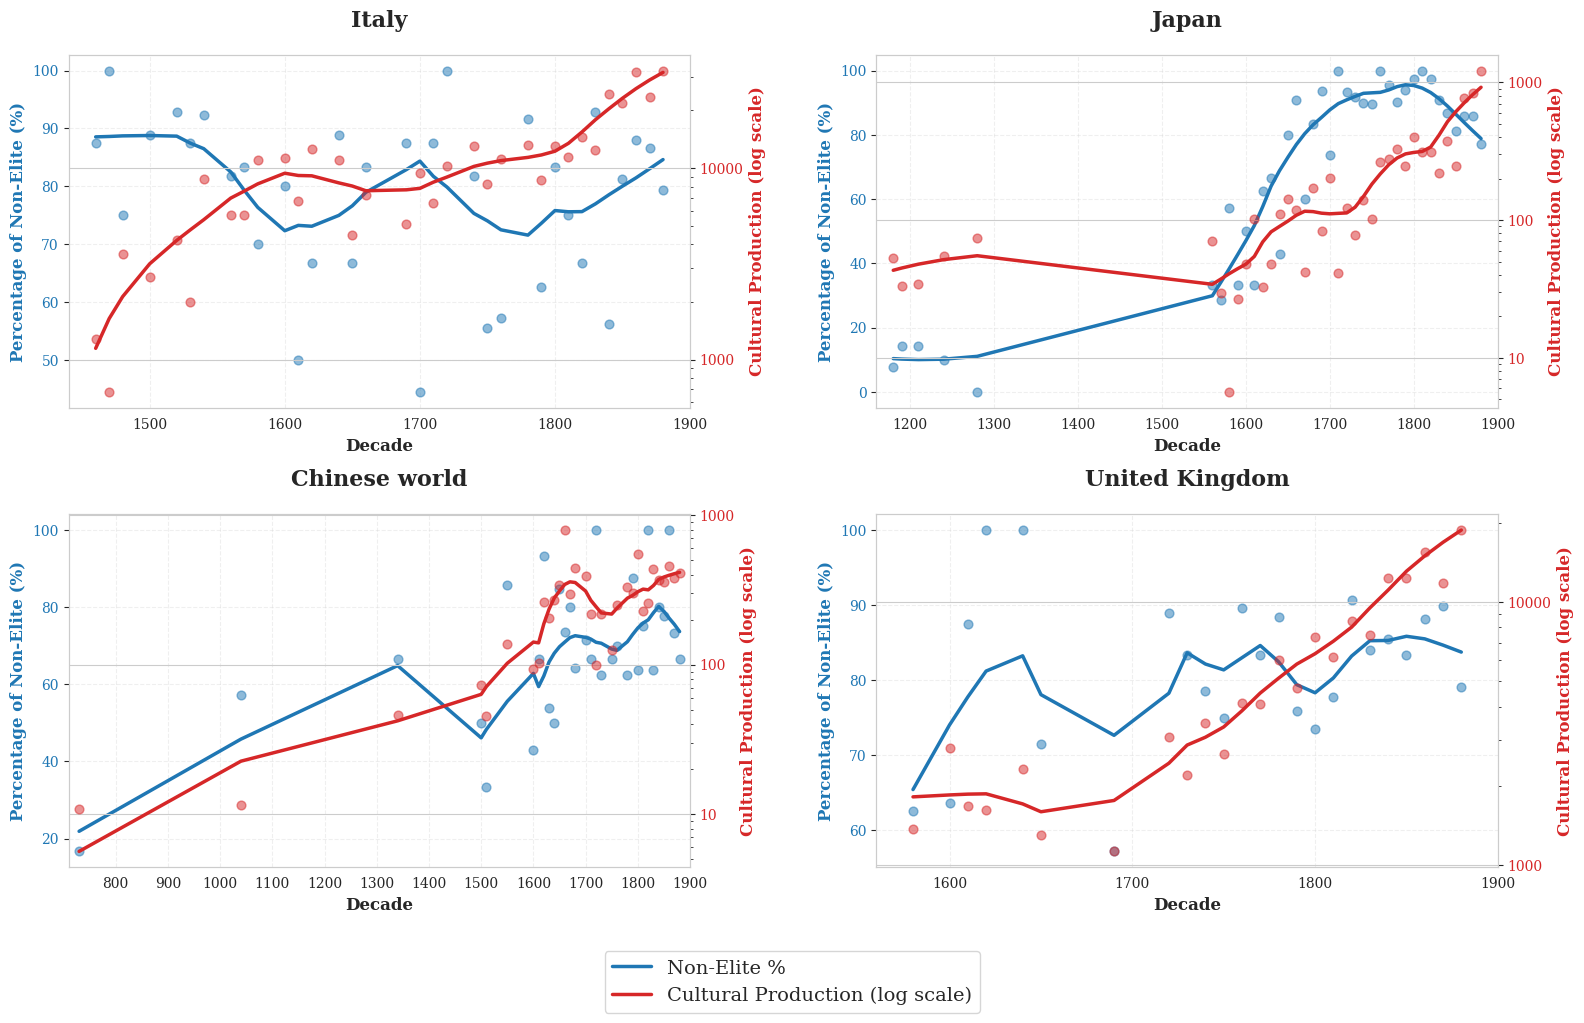

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess


pd.options.mode.chained_assignment = None



path = '../3-unseen_species_index/unseen_species_model/unseen_species_model_bayesian.csv'

df_cultura = pd.read_csv(path, index_col = [0])
df_cultura['N_est'] = df_cultura['f0'] + df_cultura['f1'] + df_cultura['f2'] # plus the individual
df_cultura = df_cultura.groupby(['region_name', 'decade']).agg({'N_est': 'sum', 'individual_wikidata_id':'count'}).reset_index()
df_cultura = df_cultura.rename(columns={"individual_wikidata_id": "score"})
# df_cultura.to_csv('data/aggregated_cpm.csv')


import pandas as pd
df_social = pd.read_csv('../2-cultura_database_extract/data/social_origins/final_sample_2.csv', index_col = [0])
df_info = pd.read_csv('../2-cultura_database_extract/db_extract/df_individuals_score.csv')
df_info = df_info[['individual_wikidata_id', 'decade']].drop_duplicates()
df_social_final = pd.merge(df_info, df_social, on = 'individual_wikidata_id')

dict_regions = {'China':'Chinese world'}

df_social_final['region_name'] = df_social_final['region_name'].apply(lambda x : dict_regions.get(x, x))
df_social_final = pd.merge(df_social_final, df_cultura, on = ['decade', 'region_name'])





# Set a beautiful style for the whole figure
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12, 
    'font.family': 'serif',
    'font.weight': 'normal',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Get unique regions from df_social_final
unique_regions = df_social_final['region_name'].unique()

# Create a figure with 4 subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()  # Flatten to easily iterate through axes

# Define consistent colors
color_non_elite = '#1f77b4'  # blue
color_cpm = '#d62728'  # red

# Process each region in its own subplot
for i, region_name in enumerate(unique_regions[:4]):  # Take first 4 regions
    # Get the current axis
    ax1 = axes[i]
    ax2 = ax1.twinx()
    
    # Filter data for current region
    df_region = df_social_final[df_social_final['region_name'] == region_name].copy()
    
    # Remove rows with NaN values in essential columns
    df_region = df_region.dropna(subset=['decade', 'classification'])
    
    # Converting 'decade' to numeric, handling NaN values
    df_region['decade'] = pd.to_numeric(df_region['decade'], errors='coerce')
    
    # Filtering out rows with NaN decade values
    df_region = df_region.dropna(subset=['decade'])
    
    # Creating a new column to identify non-elite rows (everything except 'Elite')
    df_region['non_elite'] = df_region['classification'] != 'Elite'
    
    # Grouping by decade, then counting non-elite entries
    decade_counts = df_region.groupby('decade')['non_elite'].sum().reset_index()
    
    # Calculate total counts per decade
    decade_totals = df_region.groupby('decade').size().reset_index(name='total')
    
    # Merge counts with totals
    result_df = decade_counts.merge(decade_totals, on='decade')
    
    # Calculate percentage of non-elite entries
    result_df['percentage'] = (result_df['non_elite'] / result_df['total']) * 100
    
    # Filter to include only groups with more than 5 entries
    result_df = result_df[result_df['total'] > 5]
    
    # Get N_est values for each decade (using mean if multiple values per decade)
    nest_by_decade = df_region.groupby('decade')['N_est'].mean().reset_index()
    
    # Merge with result_df
    df_final = result_df.merge(nest_by_decade, on='decade')
    df_final['region_name'] = region_name
    
    # Sort data by decade for proper visualization
    df_sorted = df_final.sort_values('decade')
    
    if len(df_sorted) > 3:  # Only plot if we have enough data points
        # Calculate LOWESS trend for percentage
        lowess_percentage = lowess(df_sorted['percentage'], df_sorted['decade'], frac=0.3, it=1)
        trend_x_percentage = lowess_percentage[:, 0]
        trend_y_percentage = lowess_percentage[:, 1]
        
        # Calculate LOWESS trend for N_est
        lowess_nest = lowess(df_sorted['N_est'], df_sorted['decade'], frac=0.3, it=1)
        trend_x_nest = lowess_nest[:, 0]
        trend_y_nest = lowess_nest[:, 1]
        
        # Plot percentage data and trend line on the primary y-axis with consistent colors
        ax1.scatter(df_sorted['decade'], df_sorted['percentage'], color=color_non_elite, s=40, alpha=0.5)
        ax1.plot(trend_x_percentage, trend_y_percentage, color=color_non_elite, linestyle='-', linewidth=2.5)
        
        ax1.set_xlabel('Decade', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Percentage of Non-Elite (%)', color=color_non_elite, fontsize=12, fontweight='bold')
        ax1.tick_params(axis='y', labelcolor=color_non_elite)
        
        # Set log scale for CPM axis
        ax2.set_yscale('log')
        
        # Plot N_est data and trend line on the secondary y-axis (log scale)
        ax2.scatter(df_sorted['decade'], df_sorted['N_est'], color=color_cpm, s=40, alpha=0.5)
        ax2.plot(trend_x_nest, trend_y_nest, color=color_cpm, linestyle='-', linewidth=2.5)
        
        ax2.set_ylabel('Cultural Production (log scale)', color=color_cpm, fontsize=12, fontweight='bold')
        ax2.tick_params(axis='y', labelcolor=color_cpm)
        
        # Format the log scale with more readable tick labels
        from matplotlib.ticker import LogFormatter
        formatter = LogFormatter(10, labelOnlyBase=False)
        ax2.yaxis.set_major_formatter(formatter)
        
        # Set ticks for appropriate decades
        min_decade = min(df_final['decade'])
        max_decade = max(df_final['decade'])
        # Round to nearest 100 below and above
        start_decade = (min_decade // 100) * 100
        end_decade = ((max_decade // 100) + 1) * 100
        ticks = np.arange(start_decade, end_decade + 100, 100)
        ax1.set_xticks(ticks)
        ax1.set_xlim(min_decade - 20, max_decade + 20)
        
        # Improve grid appearance
        ax1.grid(True, linestyle='--', alpha=0.3)
    
    # Add title for each subplot
    ax1.set_title(f"{region_name}", fontsize=16, fontweight='bold', pad=20)
    
    # # Add subtle background color for better contrast
    # ax1.set_facecolor('#f8f9fa')

# If there are fewer than 4 regions, hide the unused subplots
for j in range(len(unique_regions), 4):
    axes[j].set_visible(False)

# Create unified legend for the entire figure
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=color_non_elite, lw=2.5, label='Non-Elite %'),
    Line2D([0], [0], color=color_cpm, lw=2.5, label='Cultural Production (log scale)')
]
fig.legend(handles=legend_elements, loc='upper center', fontsize=14, 
          frameon=True, bbox_to_anchor=(0.5, 0.02))

# # Add subtle background color for better contrast
# fig.patch.set_facecolor('#f8f9fa')

# Adjust layout to avoid overlapping
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show the figure
plt.show()

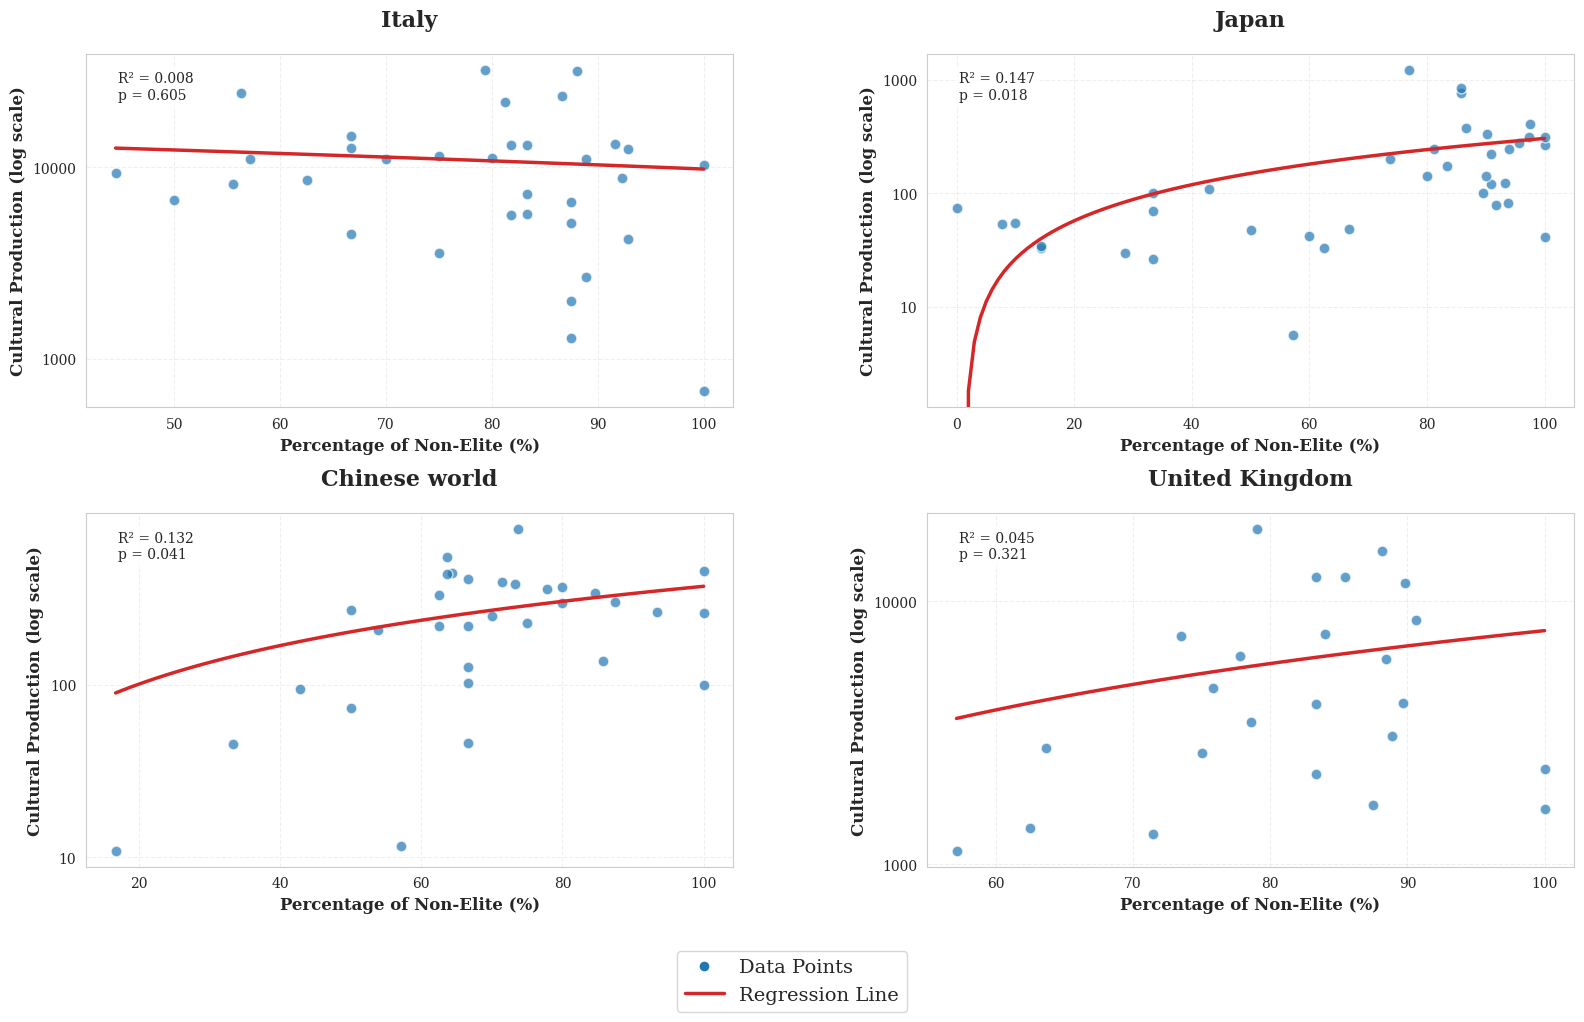

In [12]:
# Set a beautiful style for the whole figure
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 12, 
    'font.family': 'serif',
    'font.weight': 'normal',
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Get unique regions from df_social_final
unique_regions = df_social_final['region_name'].unique()

# Create a figure with 4 subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()  # Flatten to easily iterate through axes

# Define consistent colors
color_scatter = '#1f77b4'  # blue for scatter points
color_regression = '#d62728'  # red for regression line

# Import necessary libraries for regression
from scipy import stats
import numpy as np

# Process each region in its own subplot
for i, region_name in enumerate(unique_regions[:4]):  # Take first 4 regions
    # Get the current axis
    ax = axes[i]
    
    # Filter data for current region
    df_region = df_social_final[df_social_final['region_name'] == region_name].copy()
    
    # Remove rows with NaN values in essential columns
    df_region = df_region.dropna(subset=['decade', 'classification'])
    
    # Converting 'decade' to numeric, handling NaN values
    df_region['decade'] = pd.to_numeric(df_region['decade'], errors='coerce')
    
    # Filtering out rows with NaN decade values
    df_region = df_region.dropna(subset=['decade'])
    
    # Creating a new column to identify non-elite rows (everything except 'Elite')
    df_region['non_elite'] = df_region['classification'] != 'Elite'
    
    # Grouping by decade, then counting non-elite entries
    decade_counts = df_region.groupby('decade')['non_elite'].sum().reset_index()
    
    # Calculate total counts per decade
    decade_totals = df_region.groupby('decade').size().reset_index(name='total')
    
    # Merge counts with totals
    result_df = decade_counts.merge(decade_totals, on='decade')
    
    # Calculate percentage of non-elite entries
    result_df['percentage'] = (result_df['non_elite'] / result_df['total']) * 100
    
    # Filter to include only groups with more than 5 entries
    result_df = result_df[result_df['total'] > 5]
    
    # Get N_est values for each decade (using mean if multiple values per decade)
    nest_by_decade = df_region.groupby('decade')['N_est'].mean().reset_index()
    
    # Merge with result_df
    df_final = result_df.merge(nest_by_decade, on='decade')
    df_final['region_name'] = region_name
    
    # Sort data by decade for proper visualization
    df_sorted = df_final.sort_values('decade')
    
    if len(df_sorted) > 3:  # Only plot if we have enough data points
        # Extract x and y variables for regression
        x = df_sorted['percentage'].values  # Non-Elite percentage
        y = df_sorted['N_est'].values  # Cultural Production
        
        # Remove any NaN values
        mask = ~(np.isnan(x) | np.isnan(y))
        x_clean = x[mask]
        y_clean = y[mask]
        
        if len(x_clean) > 2:  # Need at least 3 points for meaningful regression
            # Create scatter plot
            ax.scatter(x_clean, y_clean, color=color_scatter, s=60, alpha=0.7, edgecolors='white', linewidth=1)
            
            # Calculate linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
            
            # Generate regression line
            x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
            y_line = slope * x_line + intercept
            
            # Plot regression line
            ax.plot(x_line, y_line, color=color_regression, linestyle='-', linewidth=2.5)
            
            # Set log scale for y-axis (Cultural Production)
            ax.set_yscale('log')
            
            # Format the log scale with more readable tick labels
            from matplotlib.ticker import LogFormatter
            formatter = LogFormatter(10, labelOnlyBase=False)
            ax.yaxis.set_major_formatter(formatter)
            
            # Add R-squared and p-value to the plot
            textstr = f'R² = {r_value**2:.3f}\np = {p_value:.3f}'
            props = dict(boxstyle='round', facecolor='white', alpha=0.8)
            ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                   verticalalignment='top', bbox=props)
            
            # Set labels
            ax.set_xlabel('Percentage of Non-Elite (%)', fontsize=12, fontweight='bold')
            ax.set_ylabel('Cultural Production (log scale)', fontsize=12, fontweight='bold')
            
            # Improve grid appearance
            ax.grid(True, linestyle='--', alpha=0.3)
    
    # Add title for each subplot
    ax.set_title(f"{region_name}", fontsize=16, fontweight='bold', pad=20)

# If there are fewer than 4 regions, hide the unused subplots
for j in range(len(unique_regions), 4):
    axes[j].set_visible(False)

# Create unified legend for the entire figure
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=color_scatter, markersize=8, 
           label='Data Points', markeredgecolor='white'),
    Line2D([0], [0], color=color_regression, lw=2.5, label='Regression Line')
]
fig.legend(handles=legend_elements, loc='upper center', fontsize=14, 
          frameon=True, bbox_to_anchor=(0.5, 0.02))

# Adjust layout to avoid overlapping
fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Show the figure
plt.show()

/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_16093/3585213544.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_counts = region_df.groupby(['period', 'classification']).size().unstack(fill_value=0)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_16093/3585213544.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_counts = region_df.groupby(['period', 'classification']).size().unstack(fill_value=0)
/var/folders/lx/9b13r6ln63jb54_3xlf9b_380000gn/T/ipykernel_16093/3585213544.py:83: FutureWarning: The default of observed=False is deprecated and will be changed to True in

NameError: name 'common_start' is not defined

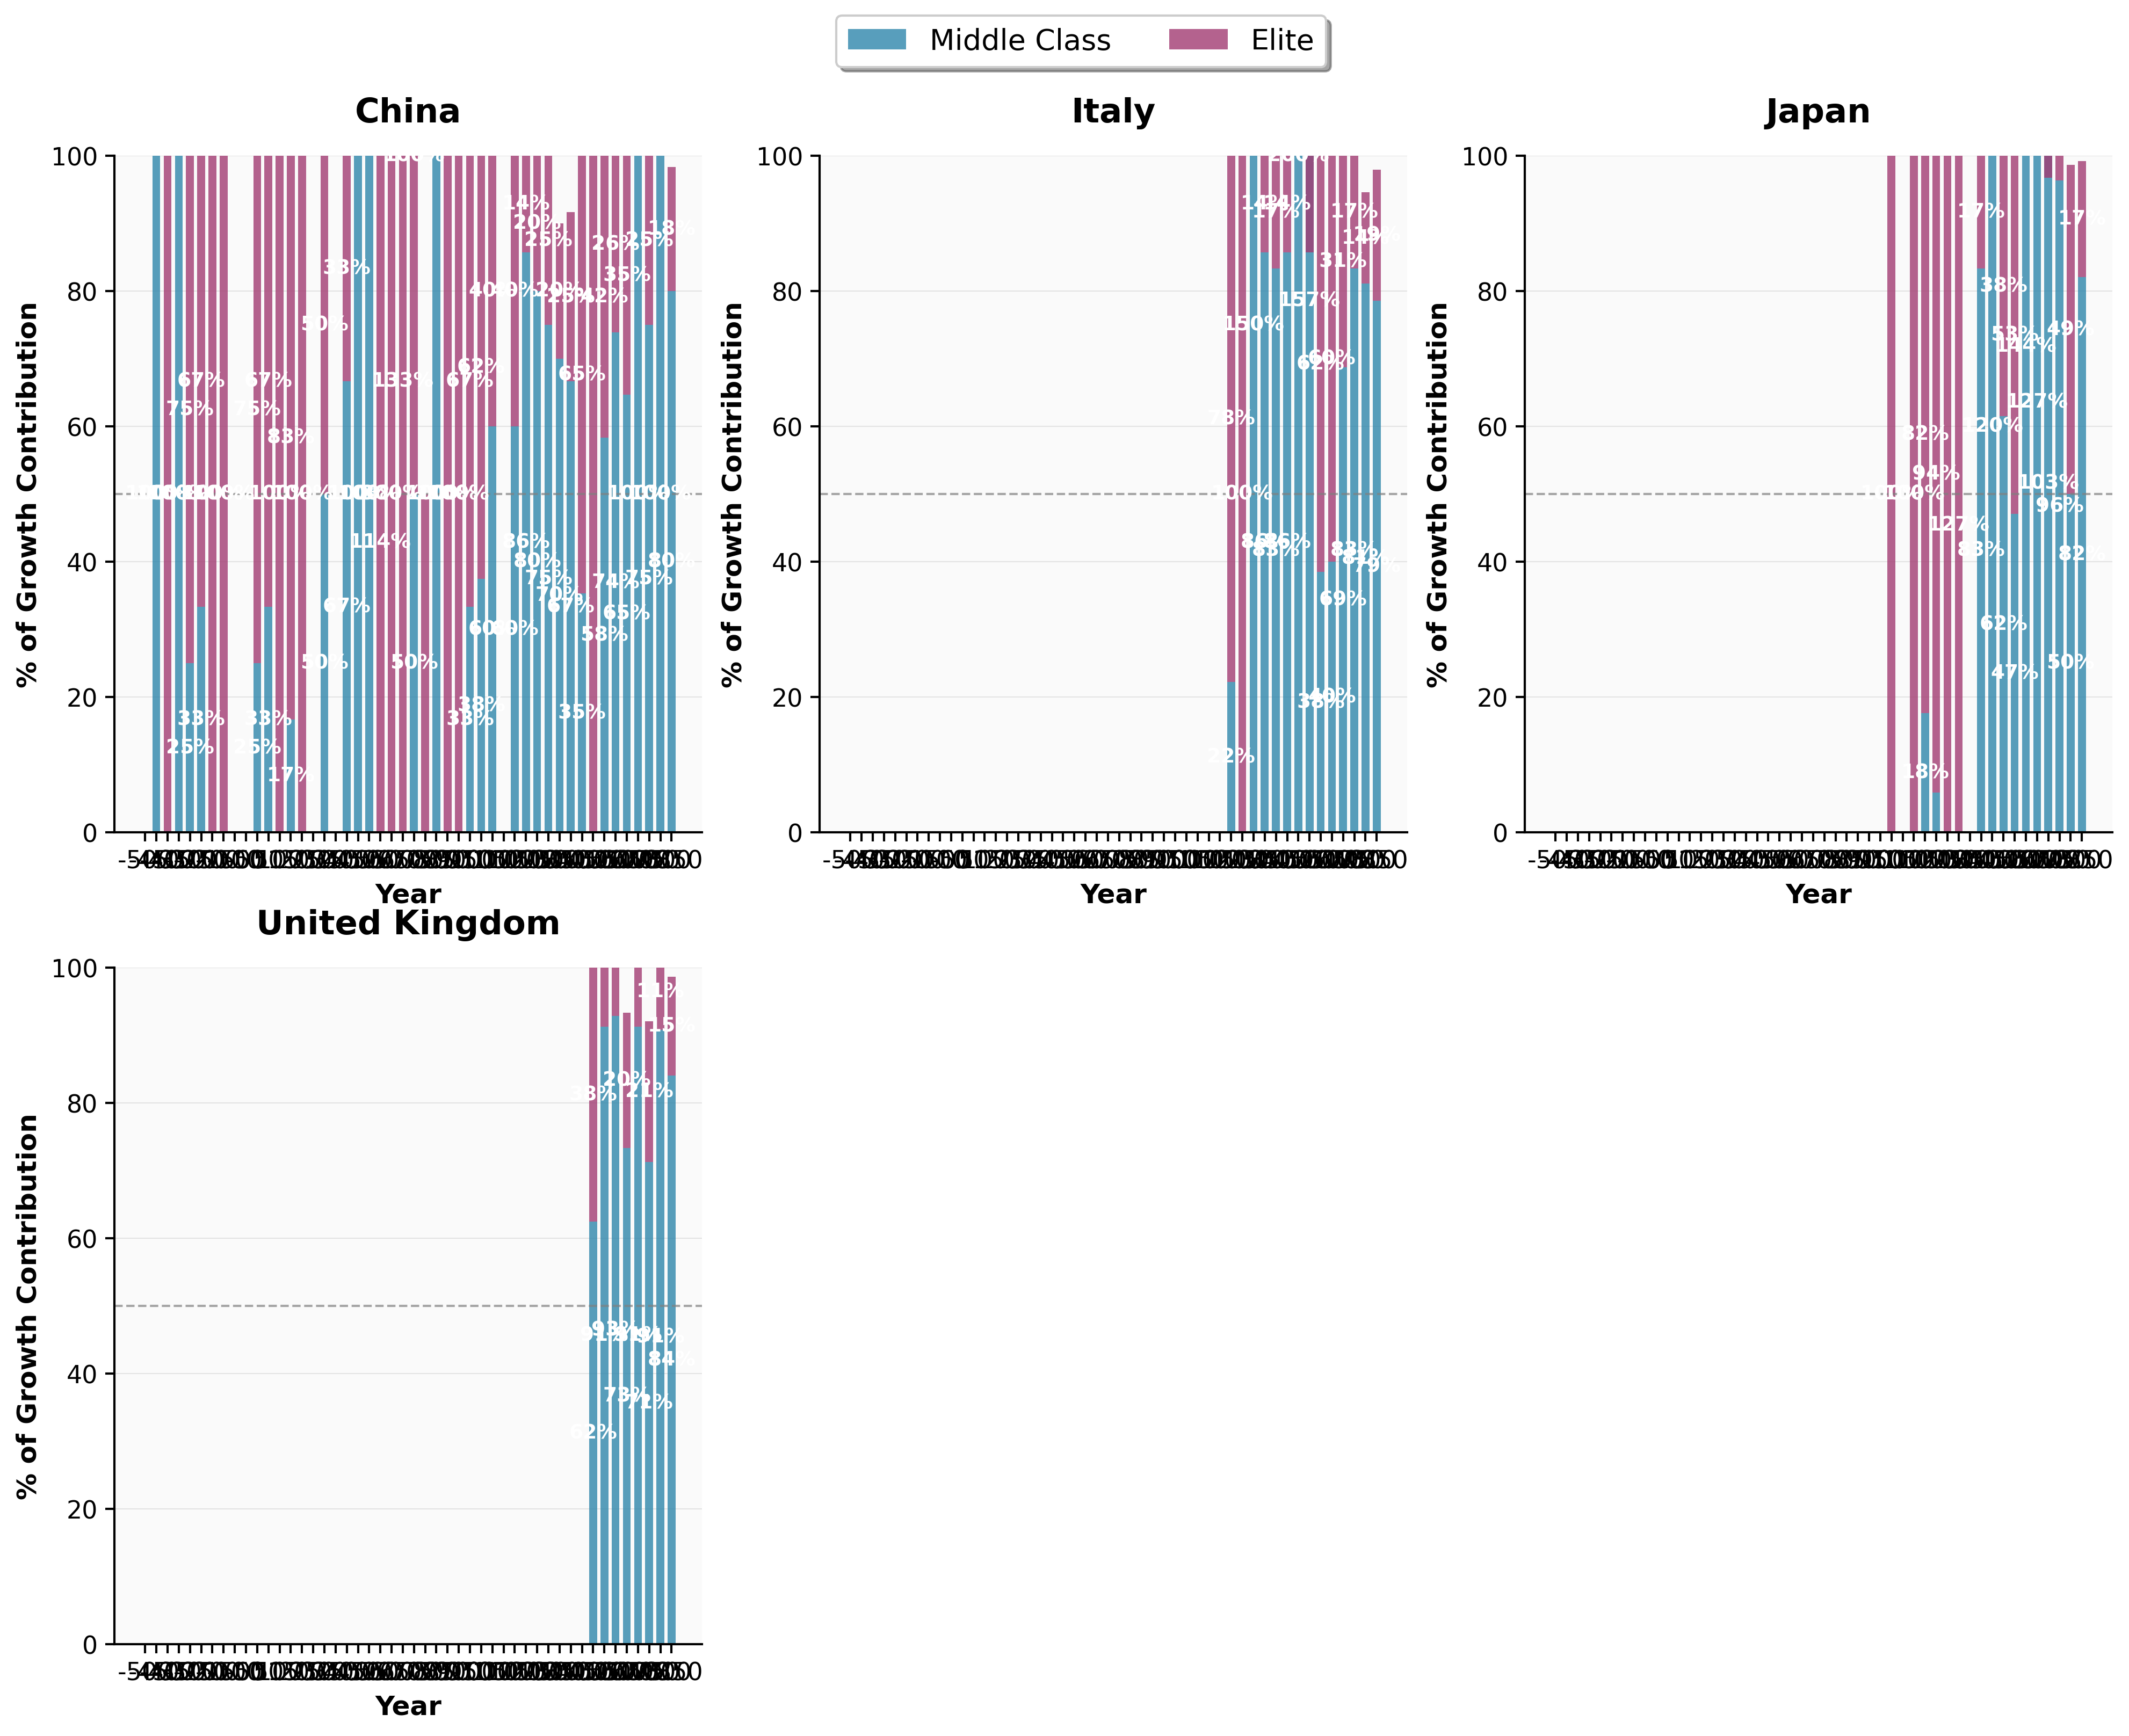